In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [4]:
import glob2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits

In [27]:
def set_plotparams(plottype):
    if plottype == 'notebook':
        plt.rcParams["figure.figsize"] = (20, 15)
        plt.rcParams["axes.titlesize"] = 24
        plt.rcParams["axes.labelsize"] = 24
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 10
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20
        plt.rcParams["legend.fontsize"] = 20
        plt.rcParams['xtick.major.size'] = 16
        plt.rcParams['xtick.minor.size'] = 8
        plt.rcParams['ytick.major.size'] = 16
        plt.rcParams['ytick.minor.size'] = 8
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'presentation':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 16
        plt.rcParams["axes.labelsize"] = 14
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 5
        plt.rcParams["xtick.labelsize"] = 12
        plt.rcParams["ytick.labelsize"] = 12
        plt.rcParams["legend.fontsize"] = 12
        plt.rcParams['xtick.major.size'] = 8
        plt.rcParams['xtick.minor.size'] = 4
        plt.rcParams['ytick.major.size'] = 8
        plt.rcParams['ytick.minor.size'] = 4
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'paper':
        plt.rcParams["figure.figsize"] = (5, 5)
        plt.rcParams["axes.titlesize"] = 14
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'

In [28]:
set_plotparams('notebook')

# Simulated X-ray sources

## Loading simulate data and plotting its properties

In [5]:
def load_sim_xmmspec(folder, background=False, numsim=20000, basename=None):
    """Load simulated XMM MOS and PN spectra."""
    if basename is None:
        basename = ''
    pn_specs = np.zeros((numsim, 4096), dtype=np.float64)
    pn_bgspecs = np.zeros((numsim, 4096), dtype=np.float64)
    mos_specs = np.zeros((numsim, 2400), dtype=np.float64)
    mos_bgspecs = np.zeros((numsim, 2400), dtype=np.float64)
    pn_mask = np.zeros(numsim, dtype=bool)
    mos_mask = np.zeros(numsim, dtype=bool)
    for i in range(numsim):
        pnfile = folder + basename + str(i) + '_PN.fak'
        mosfile = folder + basename + str(i) + '_MOS.fak'
        if os.path.isfile(pnfile):
            pn_mask[i] = True
            spec_data = fits.open(pnfile)
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pnfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                pn_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
        if os.path.isfile(mosfile):
            mos_mask[i] = True
            spec_data = fits.open(mosfile)
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                mos_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
    return ([pn_mask, mos_mask], [pn_specs, mos_specs],
            [pn_bgspecs, mos_bgspecs])

In [14]:
def plot_spec_summary(src_spec, bg_spec, ebins, det='', en_range=None):
    """Plot spectra summary"""
    if en_range is None:
        en_range = [0.2, 10.0]
    net_spec = src_spec - bg_spec
    net_counts, en_lowindex, en_highindex = get_counts_enrange(
        net_spec, en_range, ebins)
    net_spec = net_spec[:, en_lowindex:en_highindex]
    bg_counts = get_counts_enrange(bg_spec, en_range, ebins)[0]
    src_counts = get_counts_enrange(src_spec, en_range, ebins)[0]
    norm_spec = (net_spec.transpose()/net_counts).transpose()
    plt.figure()
    plt.xlabel(det + ' Energy (keV)')
    plt.ylabel('Normalized mean spectra')
    plt.plot(
        0.5*(ebins[en_lowindex:en_highindex] +
             ebins[en_lowindex+1:en_highindex+1]), np.mean(net_spec, axis=0))
    plt.xscale('log')
    plt.figure()
    plt.xlabel(r'log$_{10}$ (' + det + ' counts)')
    plt.ylabel('# per bin')
    results = plt.hist([np.log10(net_counts)[net_counts > 1],
                        np.log10(bg_counts)], bins=20)
    print(results)
    plt.legend(['Net counts', 'Scaled Background counts'])
    plt.figure()
    plt.xlabel(r'log$_{10}$ (' + det + ' background counts/' + det +
               ' net counts)')
    plt.ylabel('# per bin')
    plt.hist(np.log10(bg_counts/net_counts)[net_counts > 1], bins=20)
    plt.figure()
    plt.xlabel(r'log$_{10}$ (' + det + ' background counts/' + det +
               ' source+bg counts)')
    plt.ylabel('# per bin')
    plt.hist(np.log10(bg_counts/src_counts)[net_counts > 1], bins=20)
    plt.figure()
    plt.hist2d(np.log10(net_counts[net_counts > 1]),
               np.log10(bg_counts/net_counts)[net_counts > 1], bins=20)
    plt.xlabel(r'log$_{10}$(' + det + ' net counts)')
    plt.ylabel(r'log$_{10}$(' + det + ' bg counts/' + det + ' net counts)')
    plt.colorbar()
    plt.figure()
    plt.xlabel(r'log$_{10}$(' + det + ' net counts)')
    plt.ylabel(r'log$_{10}$(' + det + ' bg counts/' + det + ' net counts)')
    sns.kdeplot(x=np.log10(net_counts[net_counts>1]),
            y=np.log10((sim_pn_bgcounts/sim_pn_netcounts)[sim_pn_netcounts > 1]),
            fill=True)
    return net_spec, net_counts, bg_counts, en_lowindex, en_highindex


def get_enbins_centres(resp_file):
    """Get Energy bins and centres."""
    response = fits.open(resp_file)
    energy_bins = response[2].data
    emin = energy_bins['E_MIN']
    emax = energy_bins['E_MAX']
    e_centres = 0.5*(emin + emax)
    return emin, emax, e_centres


def get_counts_enrange(spec, en_range, ebin_channels):
    """Get counts in the given energy range."""
    elow_index = np.where(ebin_channels >= en_range[0])[0][0]
    ehigh_index = np.where(ebin_channels <= en_range[1])[0][-1]
    if len(spec.shape) == 1:
        return np.sum(spec[elow_index:ehigh_index])
    
    return np.sum(spec[:, elow_index:ehigh_index], axis=1), elow_index, ehigh_index

11:5: F841 local variable 'norm_spec' is assigned to but never used
61:1: W293 blank line contains whitespace


In [15]:
pn_emin, pn_emax, pn_ecentres = get_enbins_centres(
    '../XMM_responses/PN/epn_bu23_dY9.rmf.gz')
mos_emin, mos_emax, mos_ecentres = get_enbins_centres(
    '../XMM_responses/MOS_5eV/m1_e10_im_p0_c.rmf')

In [207]:
get_counts_enrange(sim_pn_specs, [2, 10], np.append(pn_emin, pn_emax[-1]))

(array([ 760.,  389., 1240., ...,    0.,    0.,    0.]), 400, 2000)

In [16]:
([sim_pn_mask, sim_mos_mask], [sim_pn_specs, sim_mos_specs],
 [sim_pn_bgs, sim_mos_bgs]) = load_sim_xmmspec('../data/sim_msps_highNH_PN_MOS/',
                                               background=True,
                                               basename='msp_highNH_')

2:80: E501 line too long (81 > 79 characters)


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


(array([[  73.,  148.,  247.,  418.,  612.,  744.,  781.,  761.,  797.,
         709.,  692.,  569.,  450.,  313.,  175.,  116.,   76.,   34.,
          15.,    3.],
       [   0.,    0.,    0.,    0.,    0.,   38.,  509.,  966., 1406.,
        1427., 1689.,  998.,  640.,  441.,  297.,  344.,  247.,  120.,
          31.,   21.]]), array([1.95015734e-03, 2.41920361e-01, 4.81890565e-01, 7.21860769e-01,
       9.61830973e-01, 1.20180118e+00, 1.44177138e+00, 1.68174159e+00,
       1.92171179e+00, 2.16168199e+00, 2.40165220e+00, 2.64162240e+00,
       2.88159261e+00, 3.12156281e+00, 3.36153301e+00, 3.60150322e+00,
       3.84147342e+00, 4.08144363e+00, 4.32141383e+00, 4.56138403e+00,
       4.80135424e+00]), <a list of 2 BarContainer objects>)


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10


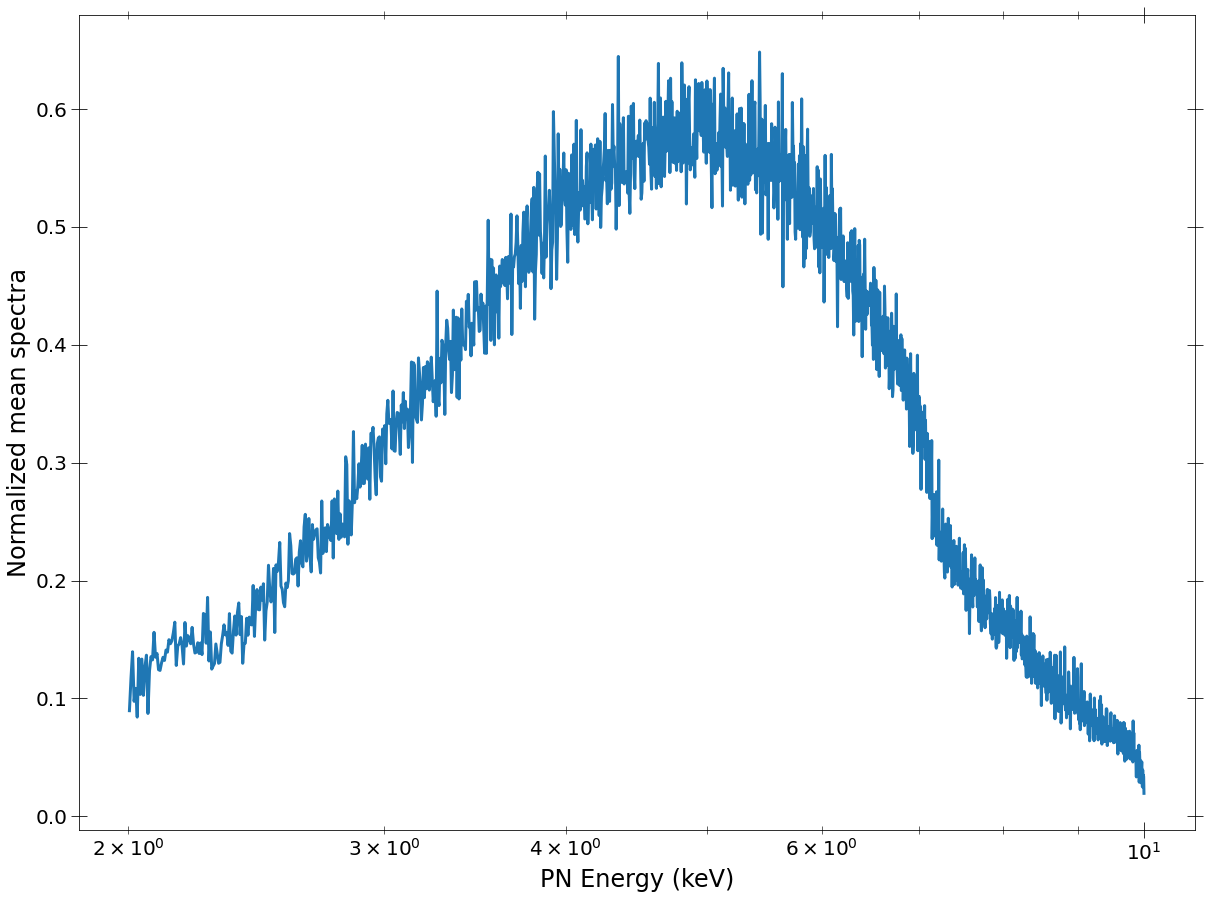

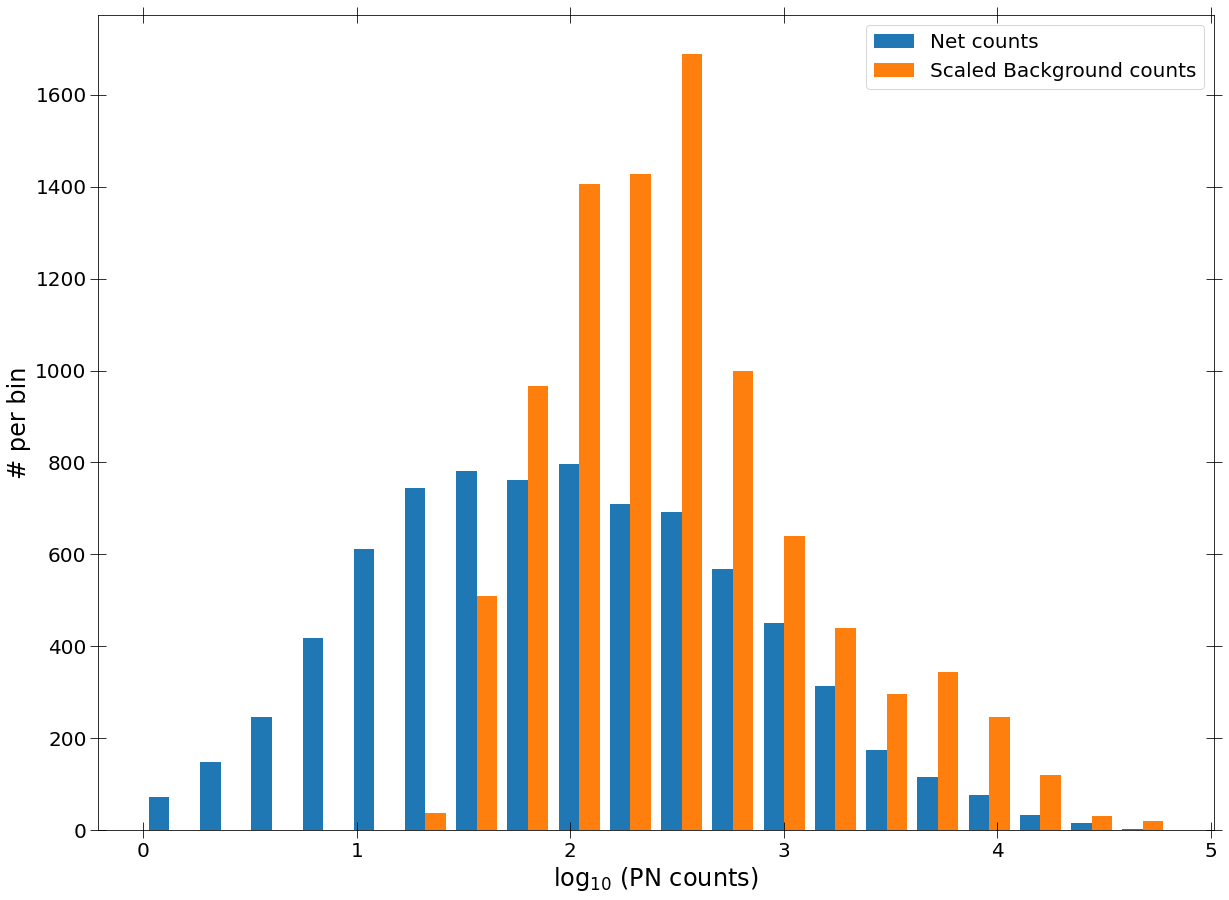

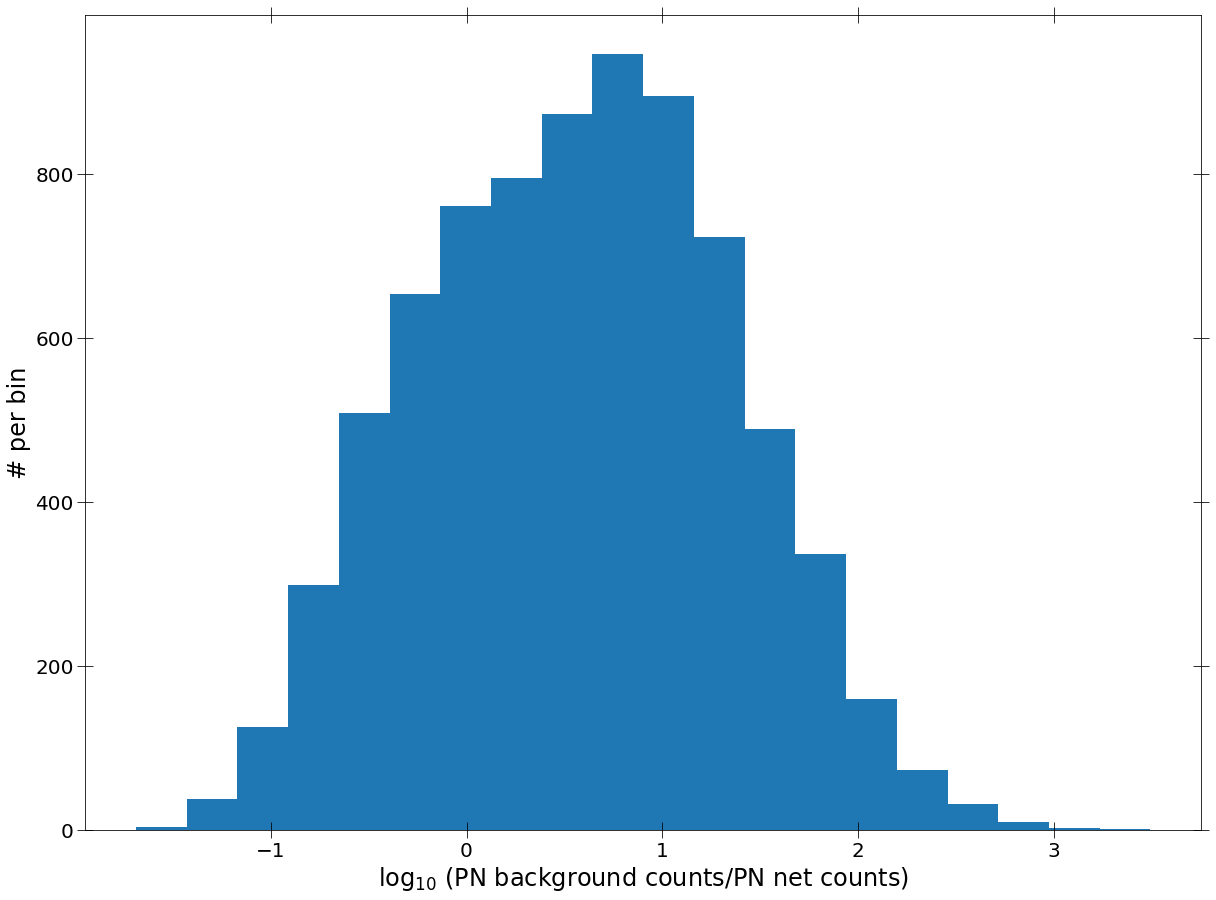

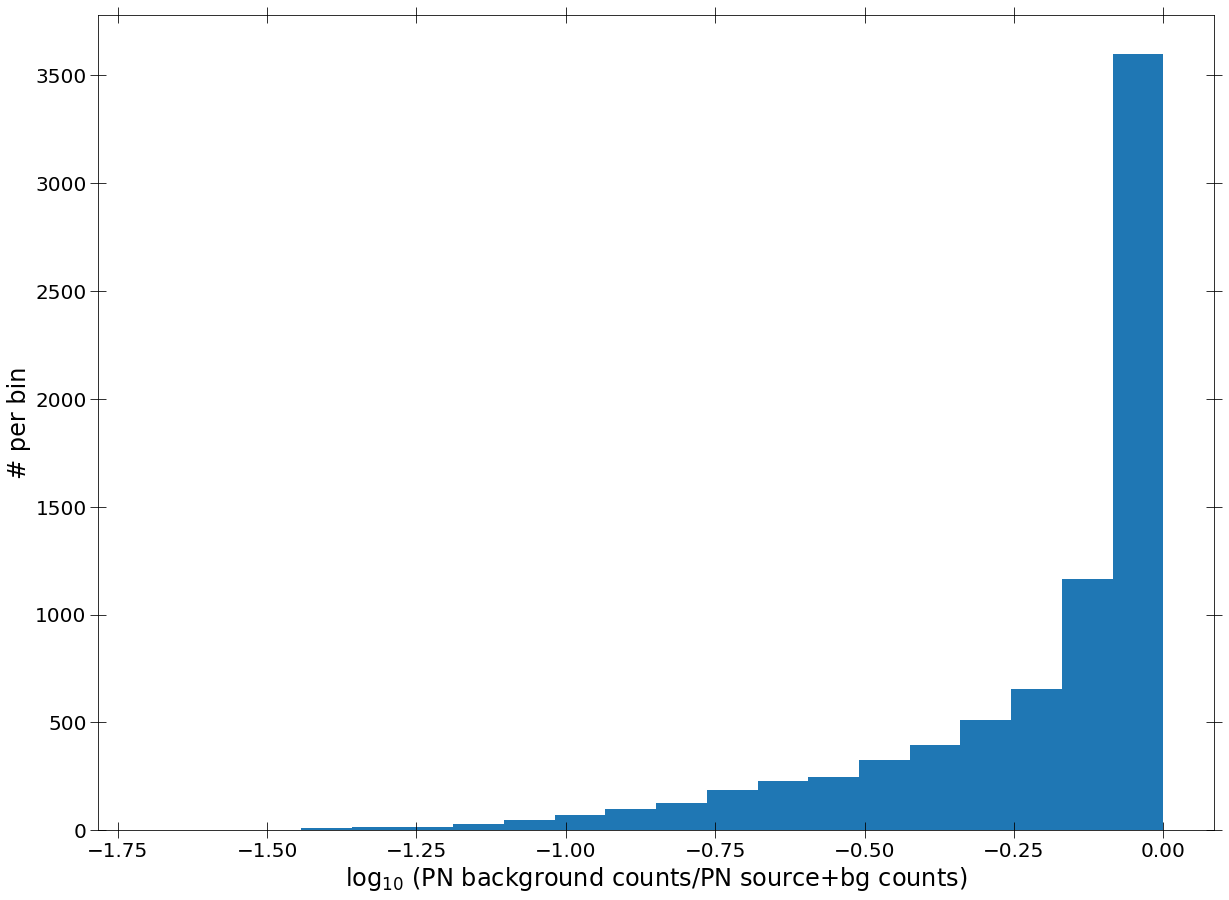

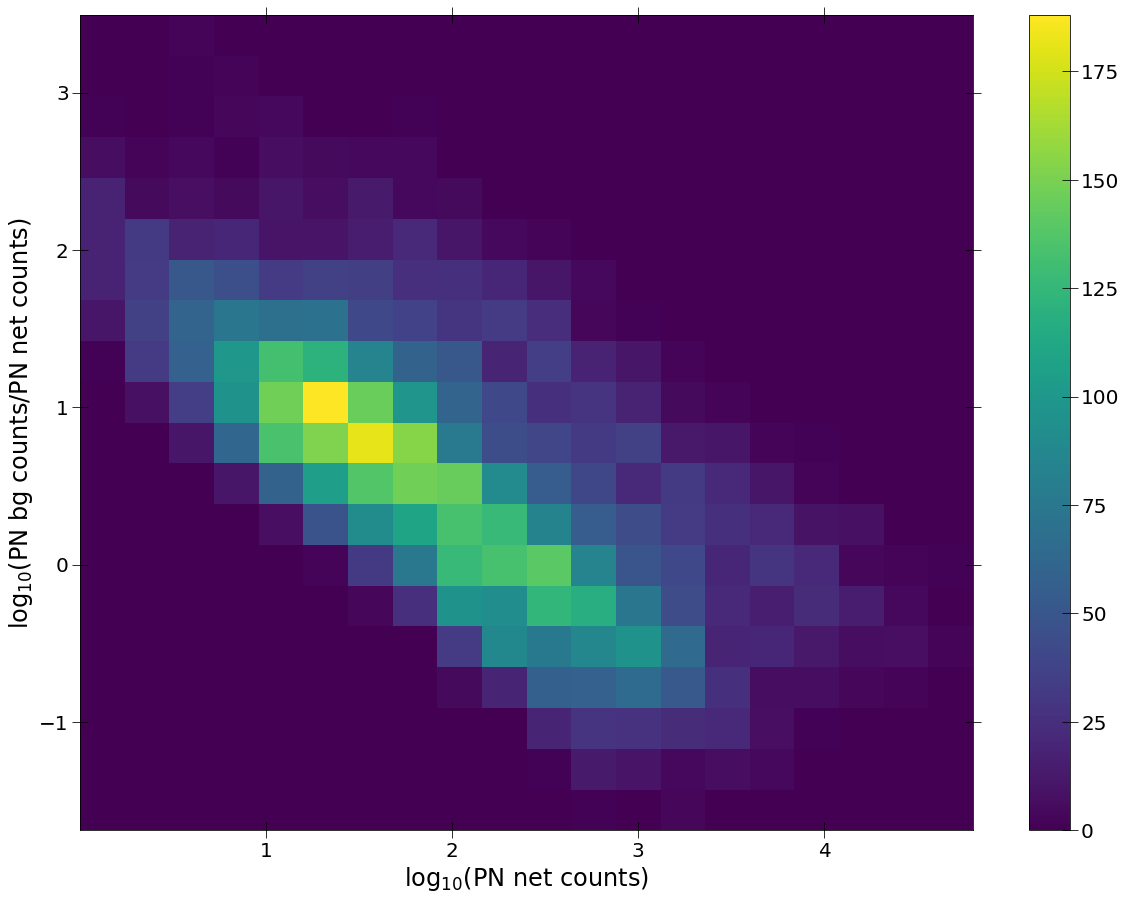

In [37]:
(sim_pn_netspec, sim_pn_netcounts, sim_pn_bgcounts, sim_pn_lowindex,
 sim_pn_highindex) = plot_spec_summary(
    sim_pn_specs[sim_pn_mask], sim_pn_bgs[sim_pn_mask],
    np.append(pn_emin, pn_emax[-1]), det='PN', en_range=[2.0, 10.0])

<AxesSubplot:>

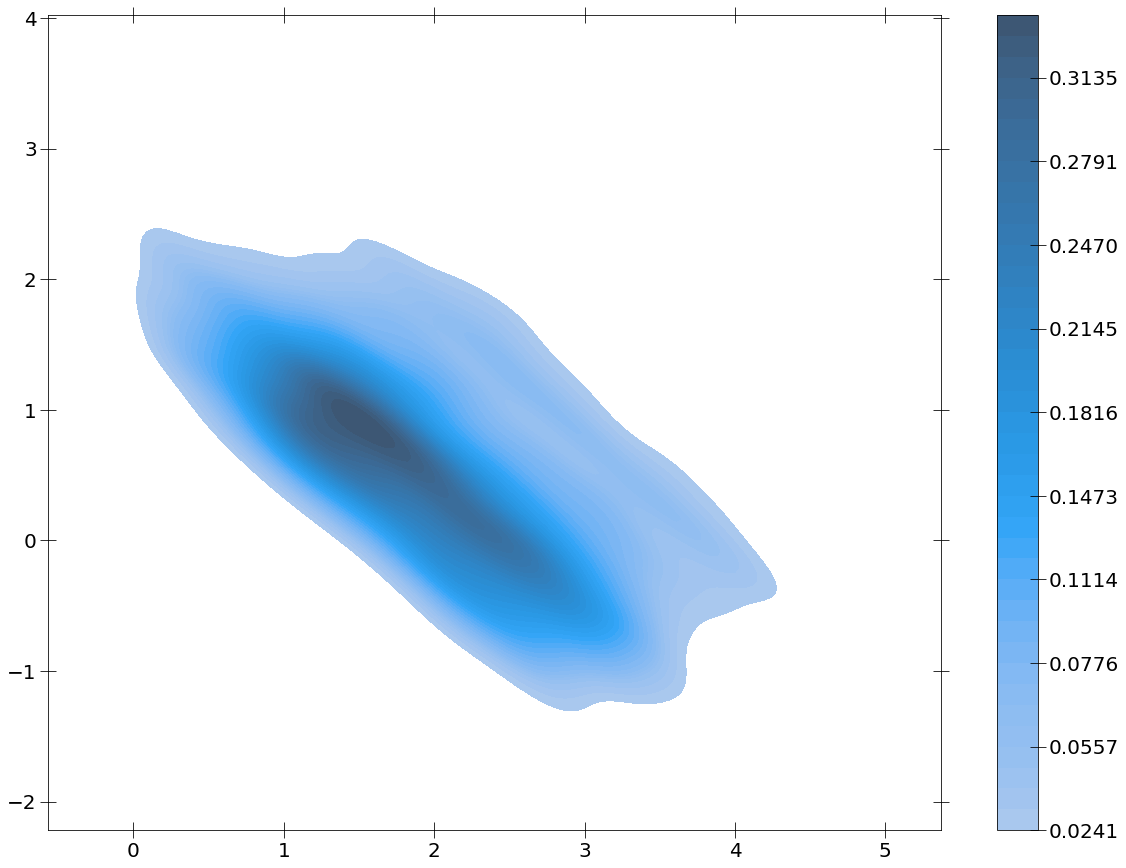

1:57: E225 missing whitespace around operator
2:80: E501 line too long (81 > 79 characters)


In [38]:
sns.kdeplot(x=np.log10(sim_pn_netcounts[sim_pn_netcounts>1]),
            y=np.log10((sim_pn_bgcounts/sim_pn_netcounts)[sim_pn_netcounts > 1]),
            fill=True, cbar=True, levels=40)

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10


(array([[ 59., 106., 157., 276., 378., 434., 471., 410., 404., 377., 359.,
        283., 227., 130.,  98.,  67.,  35.,  15.,   4.,   2.],
       [  0.,   0.,   0.,   0.,  13.,  81., 657., 733., 804., 632., 595.,
        390., 340., 297., 307., 185., 108.,  15.,  75.,   9.]]), array([1.79992794e-04, 2.30992780e-01, 4.61805566e-01, 6.92618353e-01,
       9.23431140e-01, 1.15424393e+00, 1.38505671e+00, 1.61586950e+00,
       1.84668229e+00, 2.07749507e+00, 2.30830786e+00, 2.53912065e+00,
       2.76993343e+00, 3.00074622e+00, 3.23155901e+00, 3.46237179e+00,
       3.69318458e+00, 3.92399737e+00, 4.15481015e+00, 4.38562294e+00,
       4.61643573e+00]), <a list of 2 BarContainer objects>)


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10


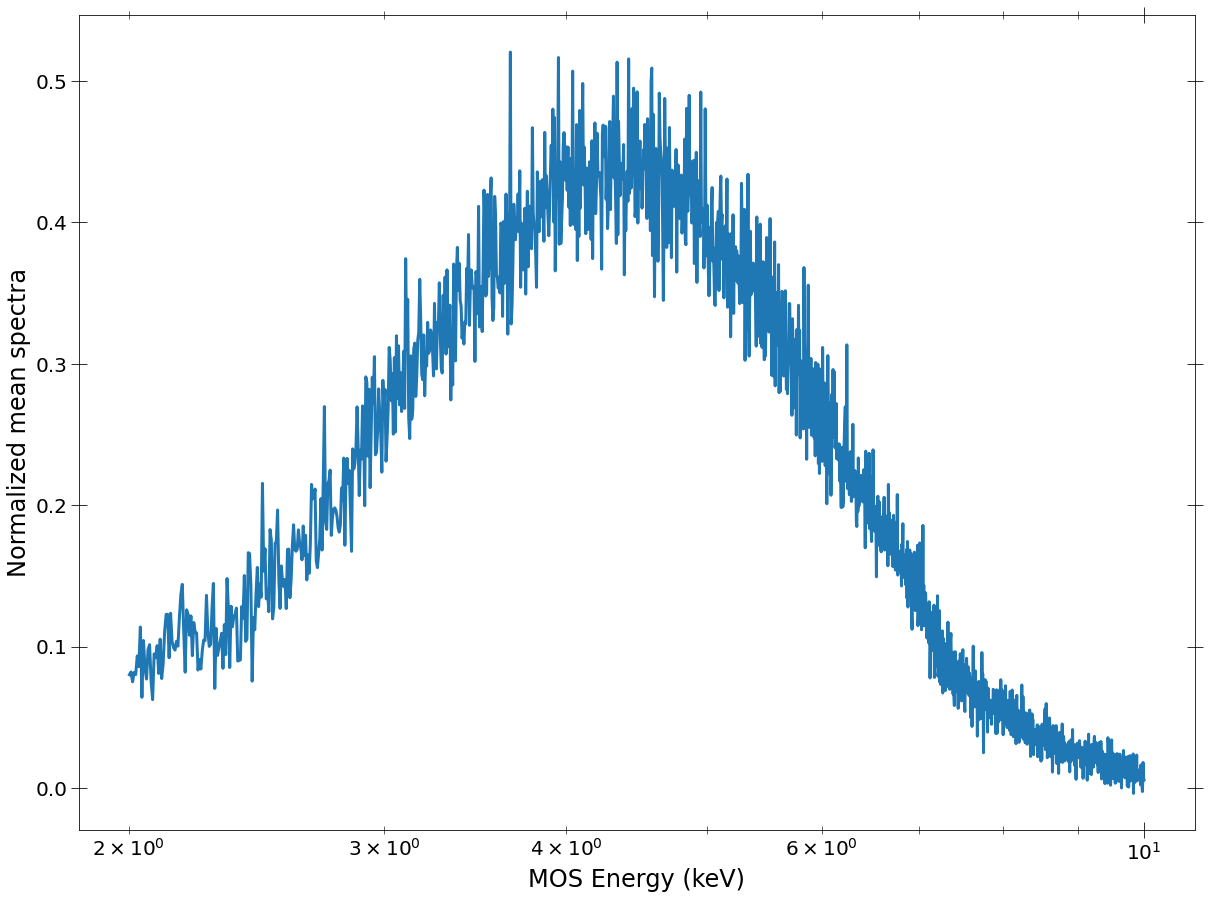

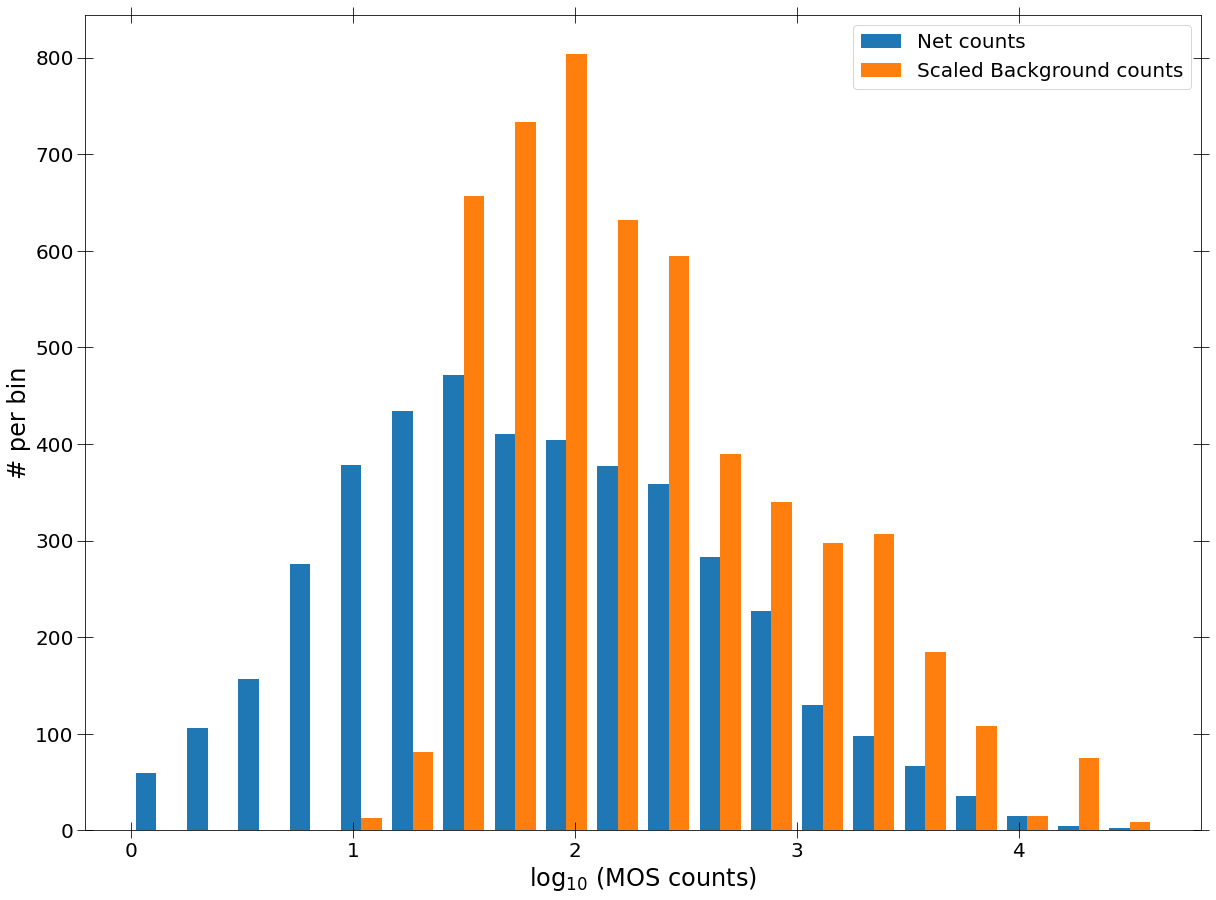

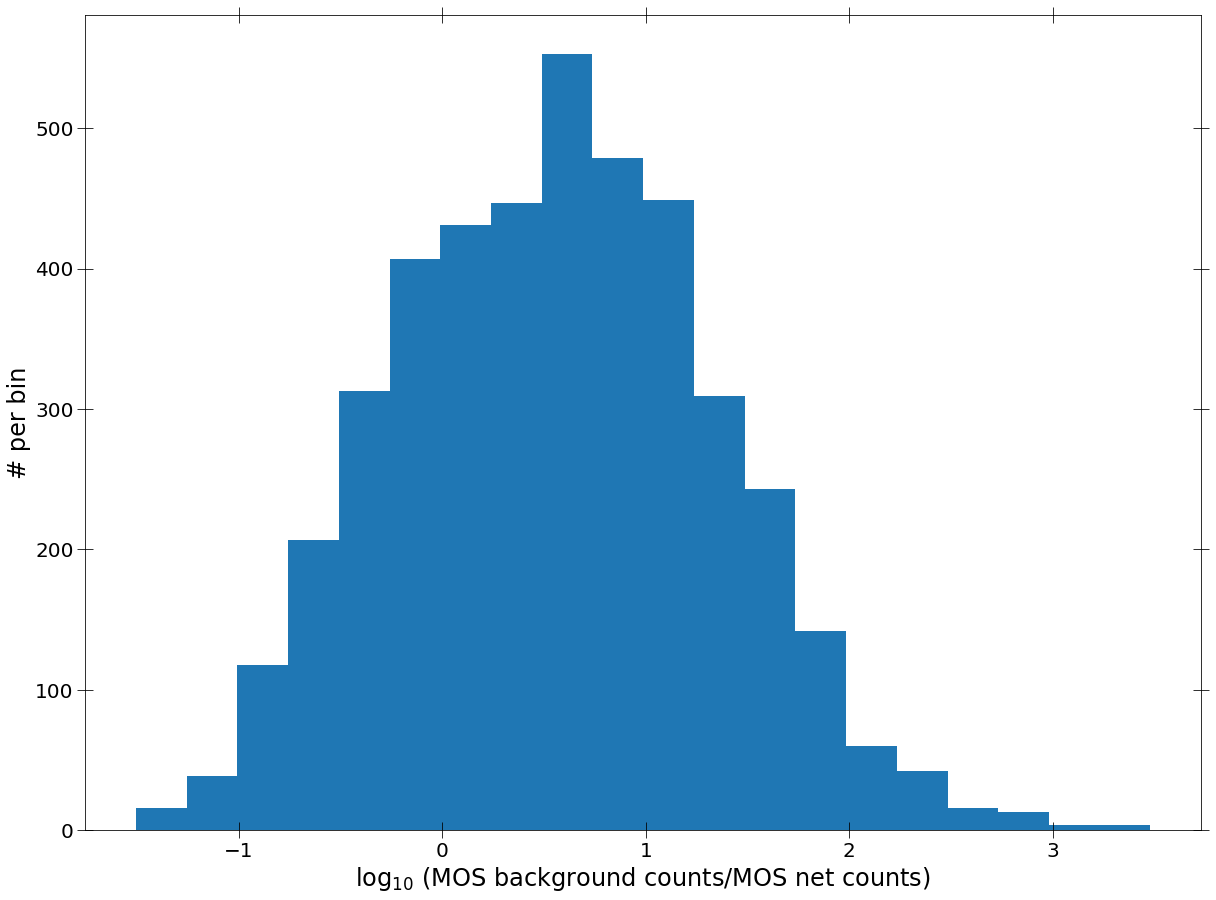

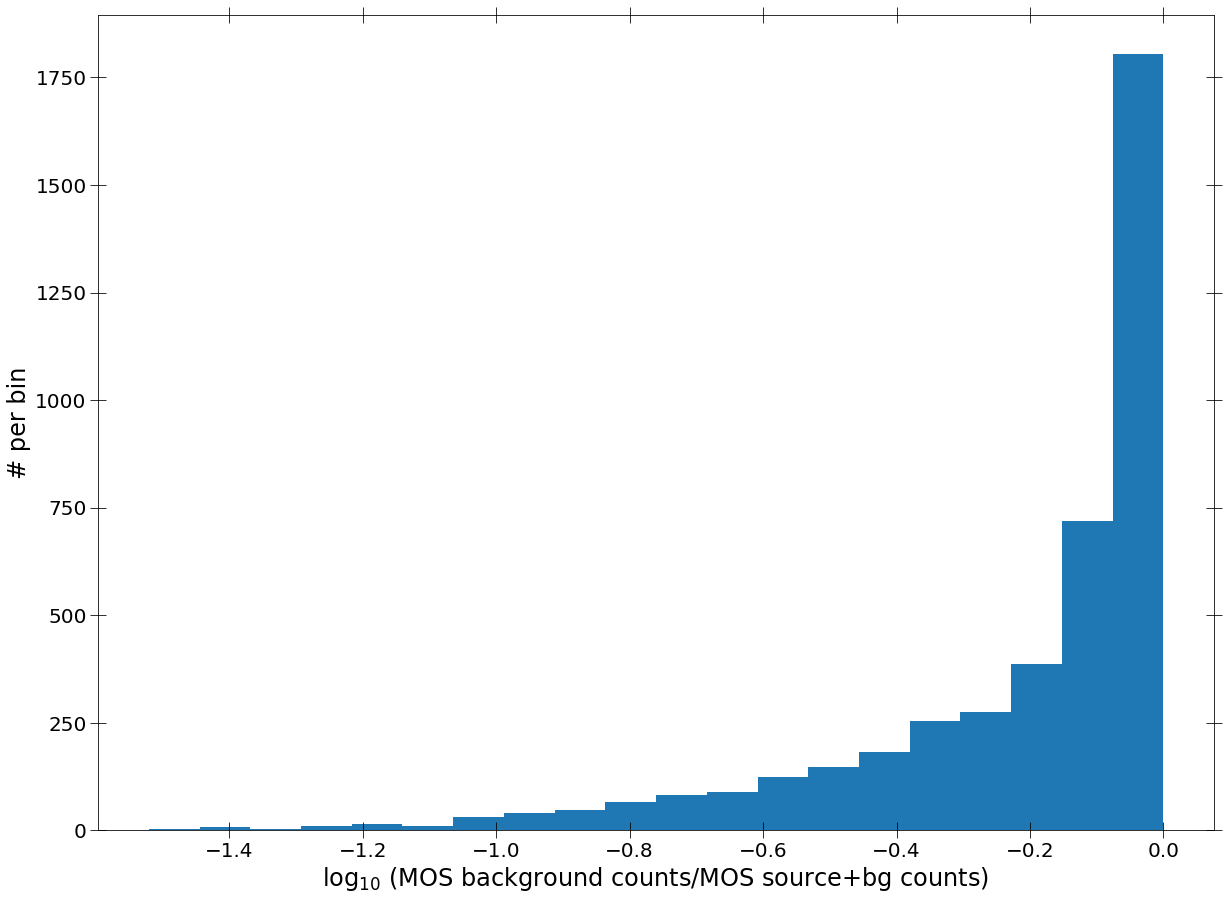

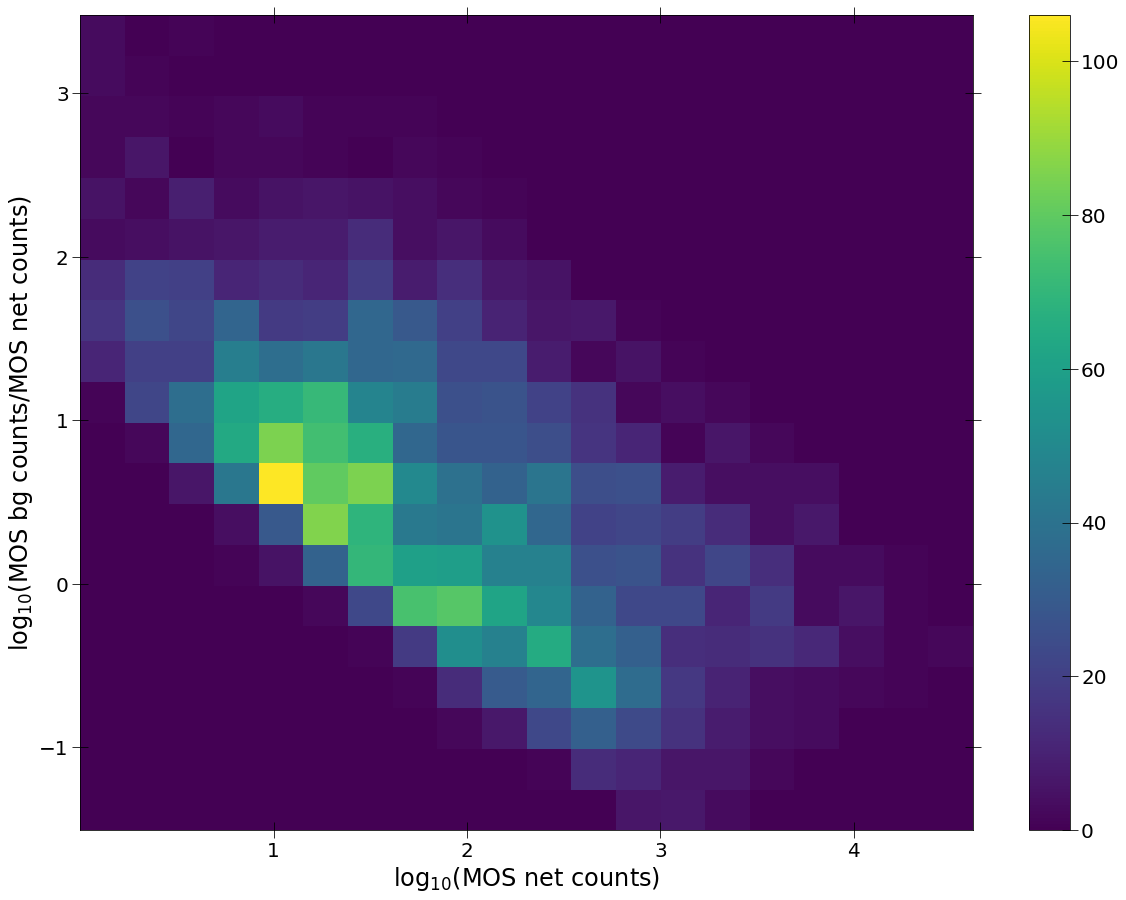

In [41]:
(sim_mos_netspec, sim_mos_netcounts, sim_mos_bgcounts, sim_mos_lowindex,
 sim_mos_highindex) = plot_spec_summary(
    sim_mos_specs[sim_mos_mask], sim_mos_bgs[sim_mos_mask],
    np.append(mos_emin, mos_emax[-1]), det='MOS', en_range=[2.0, 10.0])

<AxesSubplot:>

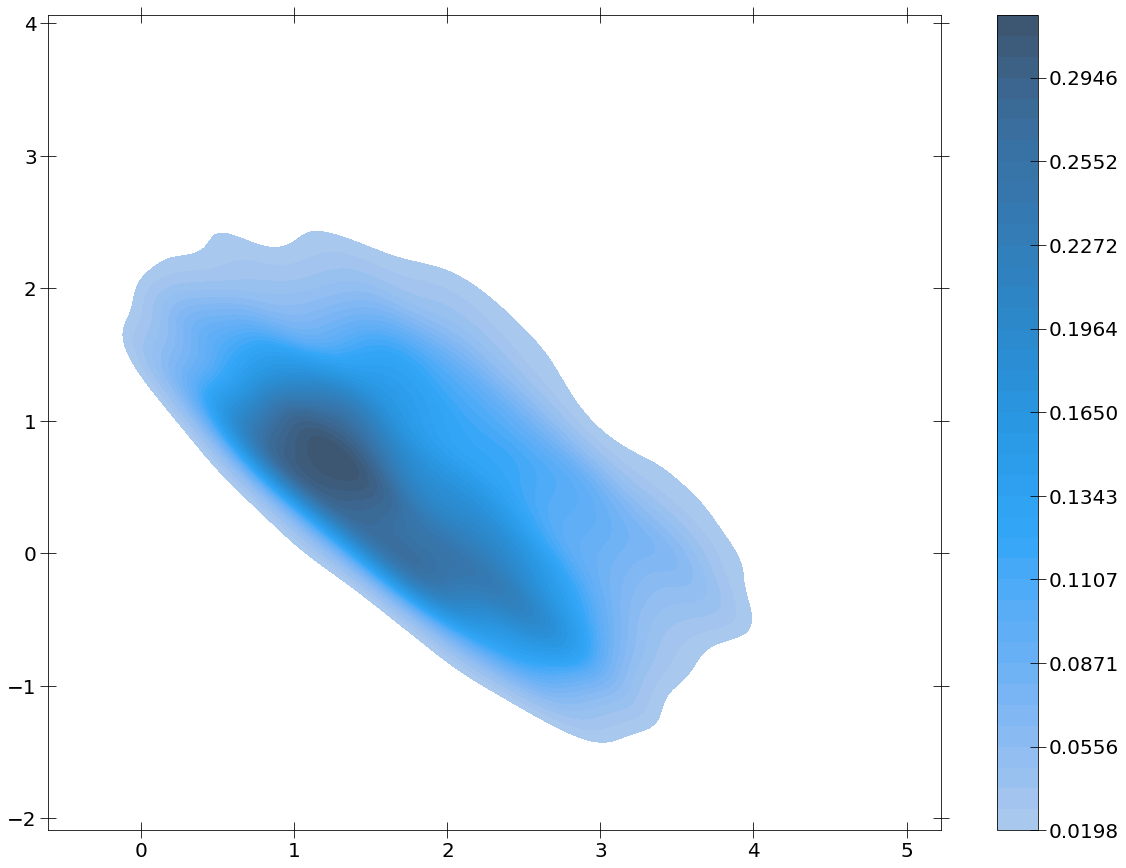

1:59: E225 missing whitespace around operator
2:80: E501 line too long (84 > 79 characters)


In [42]:
sns.kdeplot(x=np.log10(sim_mos_netcounts[sim_mos_netcounts>1]),
            y=np.log10((sim_mos_bgcounts/sim_mos_netcounts)[sim_mos_netcounts > 1]),
            fill=True, cbar=True, levels=40)

In [5]:
src_prop = np.loadtxt('../data/sim_msps_highNH_PN_MOS/param_file.txt')
nh_vals, gamma_vals, lx_vals = src_prop.transpose()

In [7]:
np.min(gamma_vals)

1.0000148957259114

(array([[  0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   1.,   2.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,   1.,
           1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  7.,   1.,   2.,   4.,   2.,   2.,   2.,   0.,   3.,   2.,   0.,
           0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  6.,   9.,   4.,   8.,   5.,   3.,   5.,   6.,   1.,   0.,   1.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 20.,  14.,  16.,  12.,  16.,  17.,  13.,  10.,   7.,   5.,   4.,
           3.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 36.,  30.,  30., 

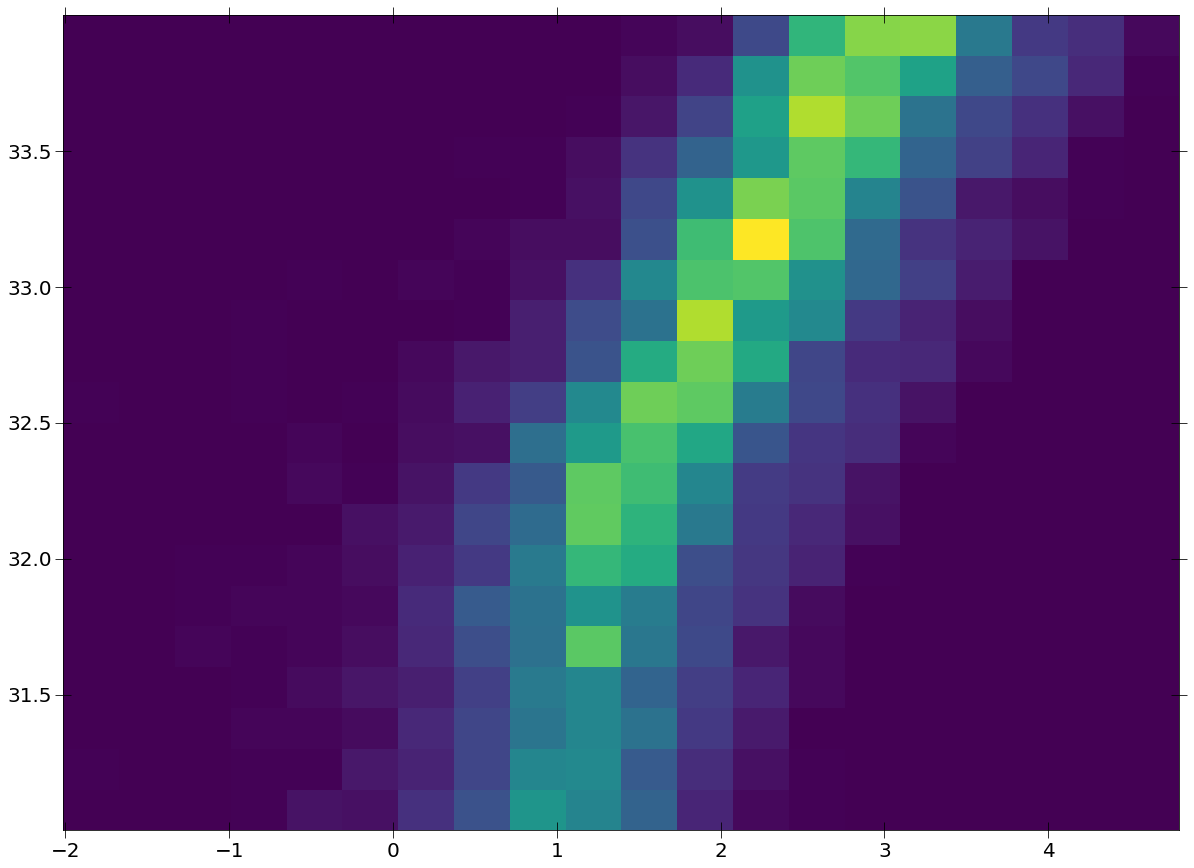

2:58: E225 missing whitespace around operator


In [44]:
plt.hist2d(np.log10(sim_pn_netcounts[sim_pn_netcounts > 0]),
           np.log10(lx_vals[sim_pn_mask][sim_pn_netcounts>0]), bins=20)

## Checking colors and how it varies with net counts, bg/net, etc.

In [45]:
def get_colors(src_spec, bg_spec, ebins, net_spec=None, range_fe=[6.1, 7.3],
               cont1_range=[5.5, 6.0], cont2_range=[7.4, 7.9]):
    if net_spec is None:
        net_spec = src_spec - bg_spec
    sim_fe_net = get_counts_enrange(net_spec, range_fe, ebins)[0]
    sim_fe_src = get_counts_enrange(src_spec, range_fe, ebins)[0]
    sim_fe_bg = get_counts_enrange(bg_spec, range_fe, ebins)[0]
                                   
    sim_cont1_net = get_counts_enrange(net_spec, cont1_range, ebins)[0]
    sim_cont1_src = get_counts_enrange(src_spec, cont1_range, ebins)[0]
    sim_cont1_bg = get_counts_enrange(bg_spec, cont1_range, ebins)[0]
    
    sim_cont2_net = get_counts_enrange(net_spec, cont2_range, ebins)[0]
    sim_cont2_src = get_counts_enrange(src_spec, cont2_range, ebins)[0]
    sim_cont2_bg = get_counts_enrange(bg_spec, cont2_range, ebins)[0]   
    return ([sim_fe_net, sim_fe_src, sim_fe_bg],
            [sim_cont1_net, sim_cont1_src, sim_cont1_bg],
            [sim_cont2_net, sim_cont2_src, sim_cont2_bg])

8:1: W293 blank line contains whitespace
12:1: W293 blank line contains whitespace
15:70: W291 trailing whitespace


In [51]:
([sim_pn_fe_net, sim_pn_fe_src, sim_pn_fe_bg],
 [sim_pn_cont1_net, sim_pn_cont1_src, sim_pn_cont1_bg],
 [sim_pn_cont2_net, sim_pn_cont2_src, sim_pn_cont2_bg]) =  get_colors(
    sim_pn_specs[sim_pn_mask][:, sim_pn_lowindex:sim_pn_highindex],
    sim_pn_bgs[sim_pn_mask][:, sim_pn_lowindex:sim_pn_highindex],
    np.append(pn_emin, pn_emax[-1]), sim_pn_netspec)

3:58: E222 multiple spaces after operator


In [47]:
sim_pn_colors = sim_pn_fe_net/(sim_pn_cont1_net + sim_pn_cont2_net)

(9, 20)

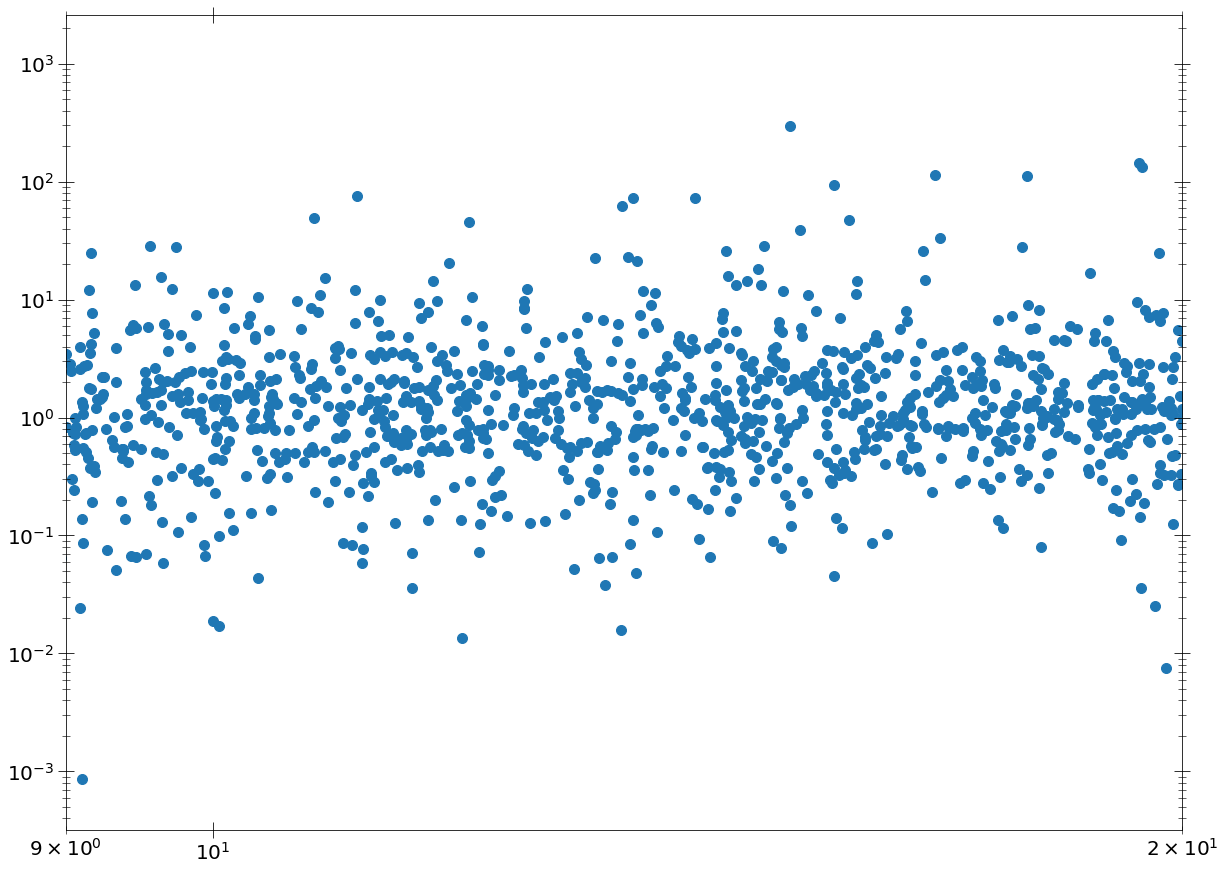

1:32: E231 missing whitespace after ','


In [183]:
plt.scatter(interested_netcount,sim_pn_colors)
plt.xscale('log')
plt.yscale('log')
plt.xlim(9, 20)

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(-2.0, 1.0)

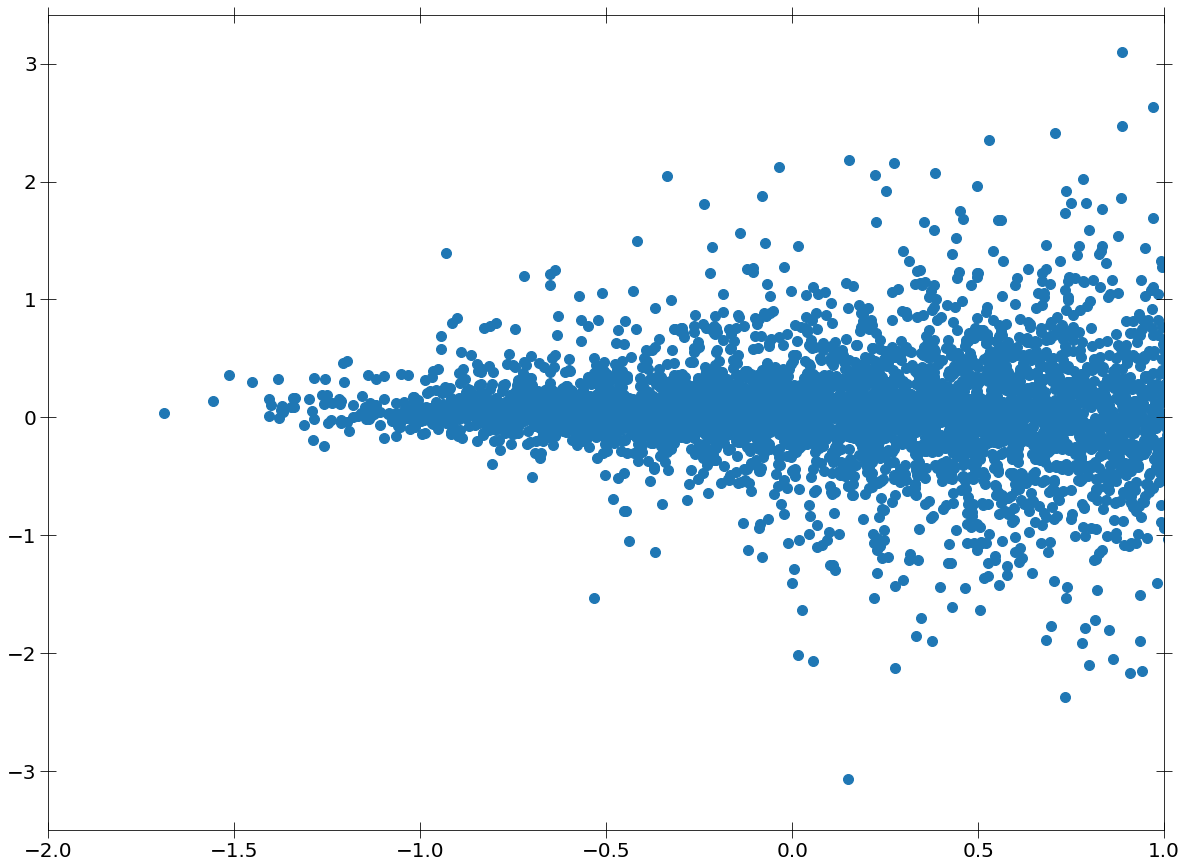

1:80: E501 line too long (80 > 79 characters)


In [49]:
plt.scatter(np.log10(sim_pn_bgcounts/sim_pn_netcounts), np.log10(sim_pn_colors))
plt.xlim(-2, 1)

In [54]:
interested_netcount = sim_pn_cont1_net+sim_pn_cont2_net+sim_pn_fe_net
interested_bg = sim_pn_cont1_bg+sim_pn_cont2_bg+sim_pn_fe_bg

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,  12.,  39.,
          49.,  34.,  32.,  26.,  13.,  11.,   2.,   2.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   9.,  38.,  83.,
          54.,  53.,  36.,  27.,   8.,   2.,   0.,   2.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   3.,  16.,  53., 100.,  90.,
          81.,  66.,  42.,  25.,   6.,   4.,   4.,   4.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   2.,   4.,  37., 123., 110., 106.,
          79.,  55.,  36.,   7.,  10.,   3.,   2.,   1.,   2.],
        [  0.,   0.,   0.,   0.,   1.,   3.,  28.,  81., 113., 149., 131.,
          98.,  51.,  24.,  13.,   8.,   2.,   4.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   4.,   7.,  88.,  66., 128., 152., 133.,
          69.,  45.,  24.,  13.,  11.,   3.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   2.,  17.,  57.,  89.,  91., 117., 131.,  84.,
          53.,  29.,  17.,  13.,   7.,   8.,   3.,   0.,   0.],
        [  0.,   0.,   2., 

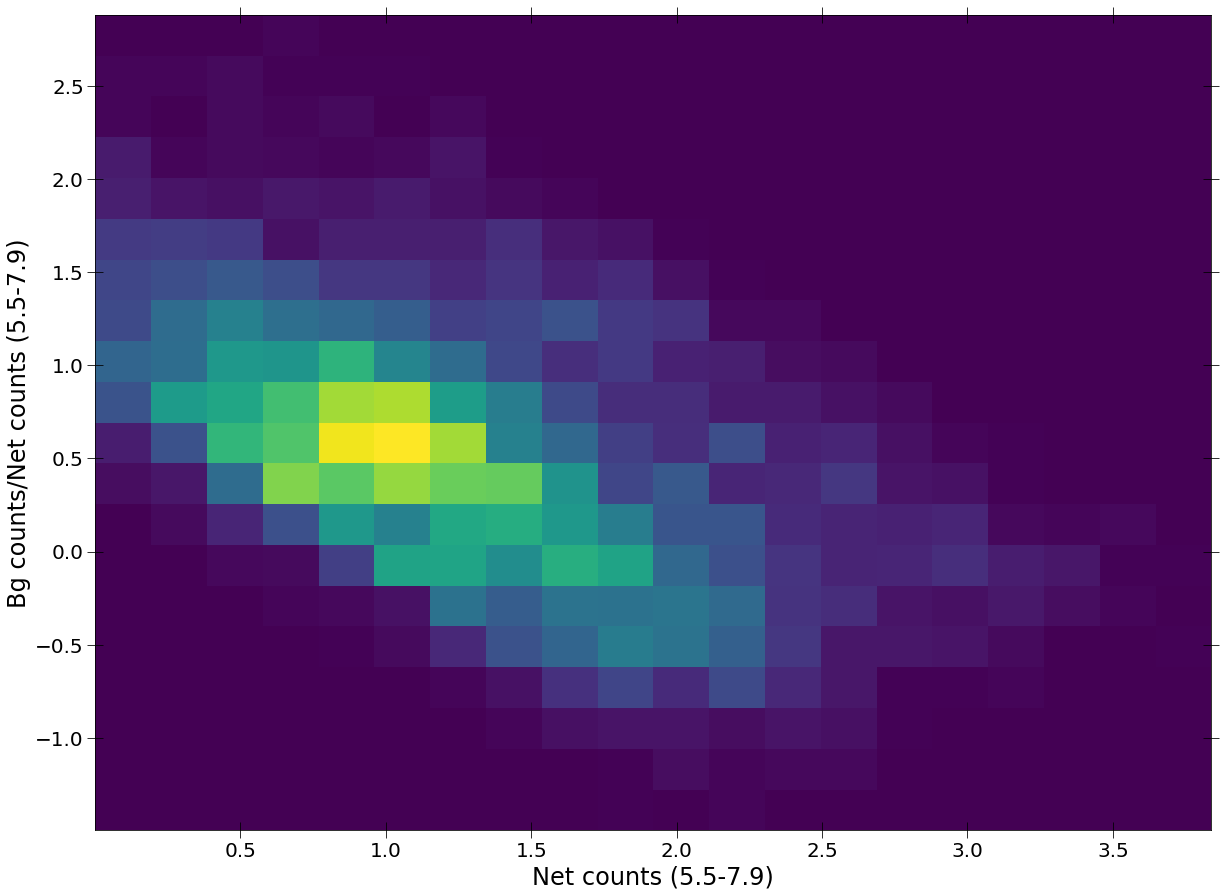

In [69]:
plt.xlabel('Net counts (5.5-7.9)')
plt.ylabel('Bg counts/Net counts (5.5-7.9)')
plt.hist2d(np.log10(interested_netcount[interested_netcount > 1]),
           np.log10(interested_bg[interested_netcount > 1]/interested_netcount[interested_netcount > 1]), bins=20)

(array([[  7.,   6.,  13.,  27.,  36.,  25.,  31.,  12.,  11.,   3.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  4.,   9.,  23.,  36.,  48.,  58.,  28.,  35.,  10.,   1.,   1.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  6.,  13.,  21.,  50.,  59.,  76.,  78.,  56.,  34.,  12.,   1.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 10.,  13.,  27.,  38.,  61.,  90., 110.,  75.,  41.,  11.,   6.,
           1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  6.,   7.,  11.,  41.,  63.,  84., 117., 121., 115.,  54.,  18.,
           2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  4.,   6.,   9.,  17.,  35.,  74.,  91., 152., 168., 105.,  36.,
           3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   3.,   3.,   5.,  10.,  20.,  57., 104., 193., 190.,  95.,
          11.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   1.,   1., 

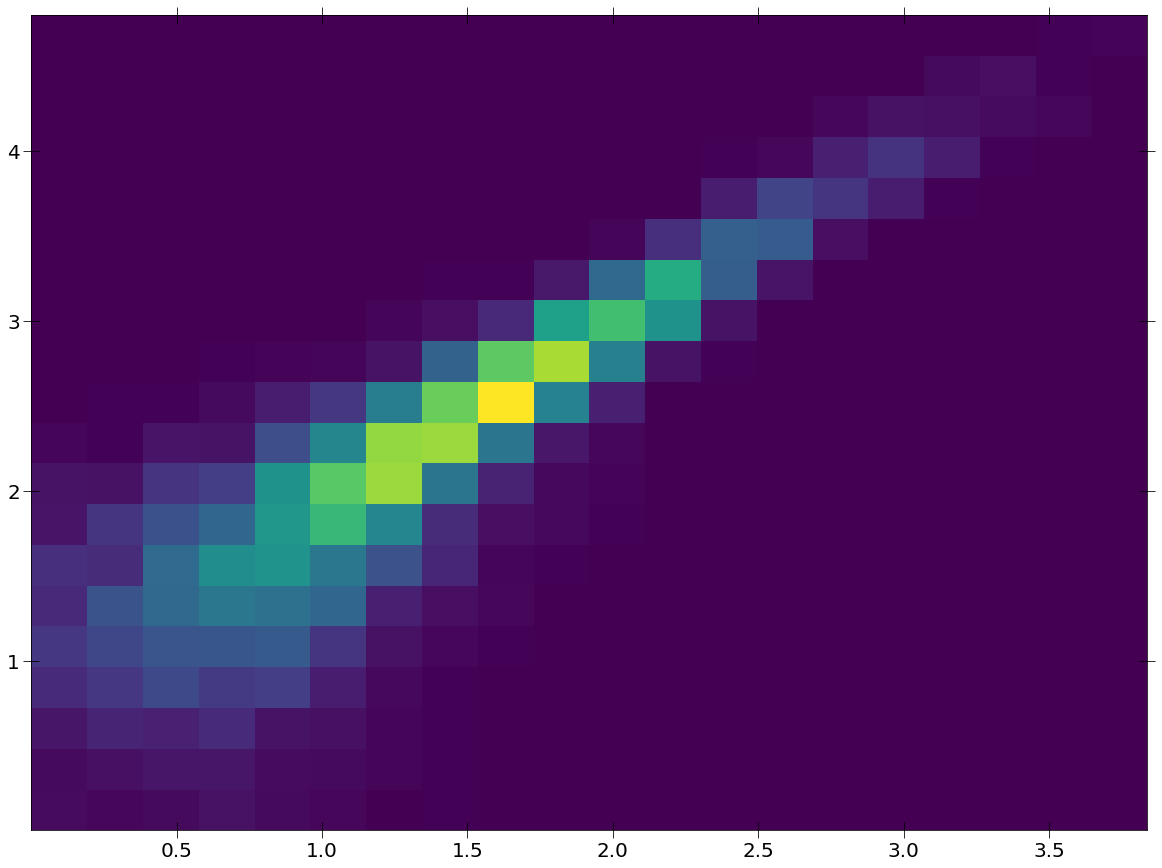

1:80: E501 line too long (104 > 79 characters)


In [68]:
plt.hist2d(np.log10(interested_netcount[np.logical_and(sim_pn_netcounts > 1, interested_netcount > 1)]),
           np.log10(sim_pn_netcounts[np.logical_and(sim_pn_netcounts > 1, interested_netcount > 1)]), bins=20)

In [165]:
def get_expected_colors(counts_line_net, counts_cont1_net, counts_cont2_net,
                        src_prop, srcprop_bins):
    """Get expected color for given bins"""
    colors = counts_line_net/(counts_cont1_net + counts_cont2_net)
    mean_colors = np.zeros(len(srcprop_bins)-1)
    colors_std = np.zeros(len(srcprop_bins)-1)
    for i, bin_edge in enumerate(srcprop_bins[:-1]):
        mean_colors[i], colors_std[i] = get_expected_color_bins(
            colors, src_prop, [bin_edge, srcprop_bins[i+1]])
    return mean_colors, colors_std
    

def get_expected_color_bins(colors, src_prop, bin_edges):
    """Get expected color for each bin"""
    mask = np.where(np.logical_and(src_prop >= bin_edges[0], src_prop < bin_edges[1]))
    bin_colors = colors[mask]
    print(len(mask[0]))
    return np.mean(bin_colors), np.std(bin_colors)

11:1: W293 blank line contains whitespace
15:80: E501 line too long (86 > 79 characters)


In [72]:
net_count_bins = 10**np.histogram(np.log10(sim_pn_netcounts[sim_pn_netcounts > 1]), bins=20)[1]

In [167]:
np.histogram(np.log10(sim_pn_netcounts[sim_pn_netcounts > 1]), bins=20)

(array([ 73, 148, 247, 418, 612, 744, 781, 761, 797, 709, 692, 569, 450,
        313, 175, 116,  76,  34,  15,   3]),
 array([1.95015734e-03, 2.41920361e-01, 4.81890565e-01, 7.21860769e-01,
        9.61830973e-01, 1.20180118e+00, 1.44177138e+00, 1.68174159e+00,
        1.92171179e+00, 2.16168199e+00, 2.40165220e+00, 2.64162240e+00,
        2.88159261e+00, 3.12156281e+00, 3.36153301e+00, 3.60150322e+00,
        3.84147342e+00, 4.08144363e+00, 4.32141383e+00, 4.56138403e+00,
        4.80135424e+00]))

In [75]:
netcount_bincentres = 0.5*(net_count_bins[:-1]+net_count_bins[1:])

In [166]:
mean_colors_netcounts, colors_std_netcounts = get_expected_colors(
    sim_pn_fe_net, sim_pn_cont1_net, sim_pn_cont2_net, sim_pn_netcounts, net_count_bins)

73
148
247
418
612
744
781
761
797
709
692
569
450
313
175
116
76
34
15
3


(-5.0, 5.0)

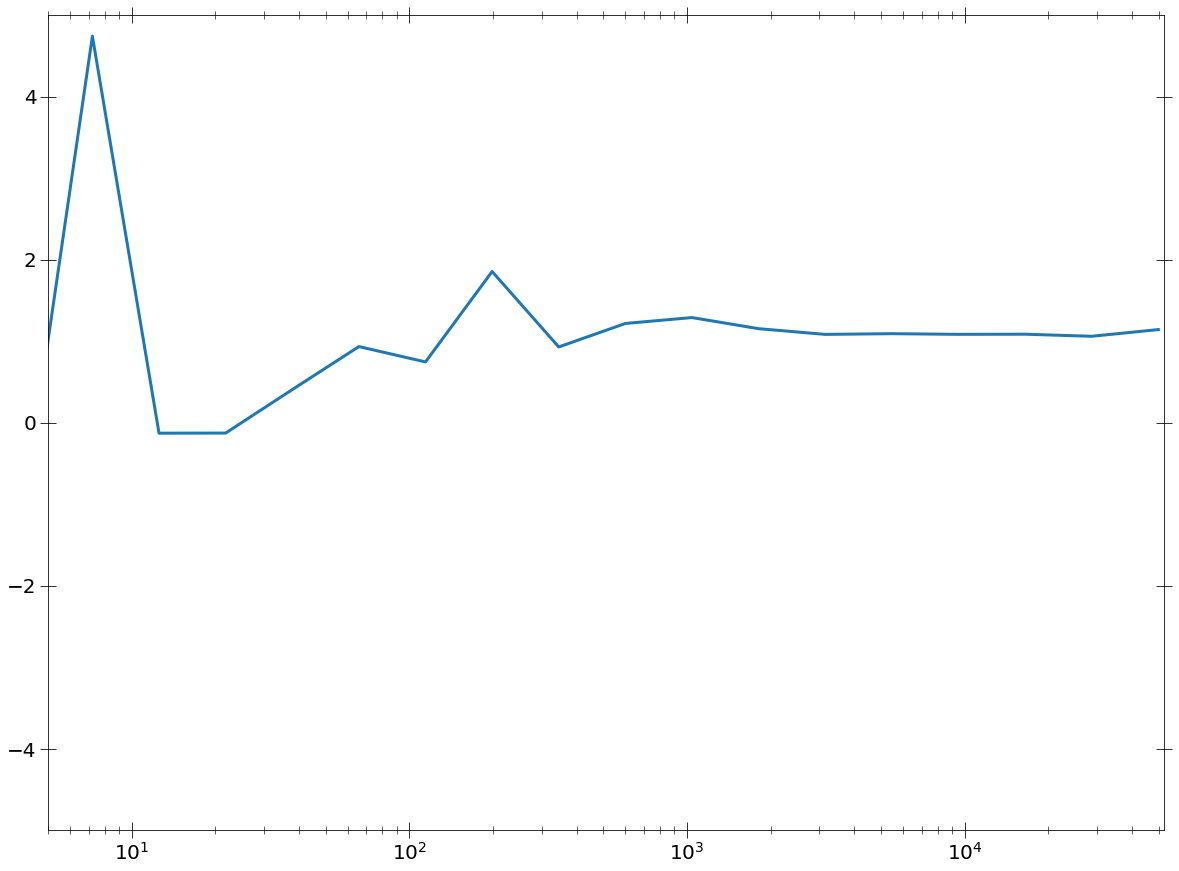

In [169]:
plt.plot(netcount_bincentres, mean_colors_netcounts)
plt.xlim(5)
plt.xscale('log')
plt.ylim(-5, 5)

(0.01, 100)

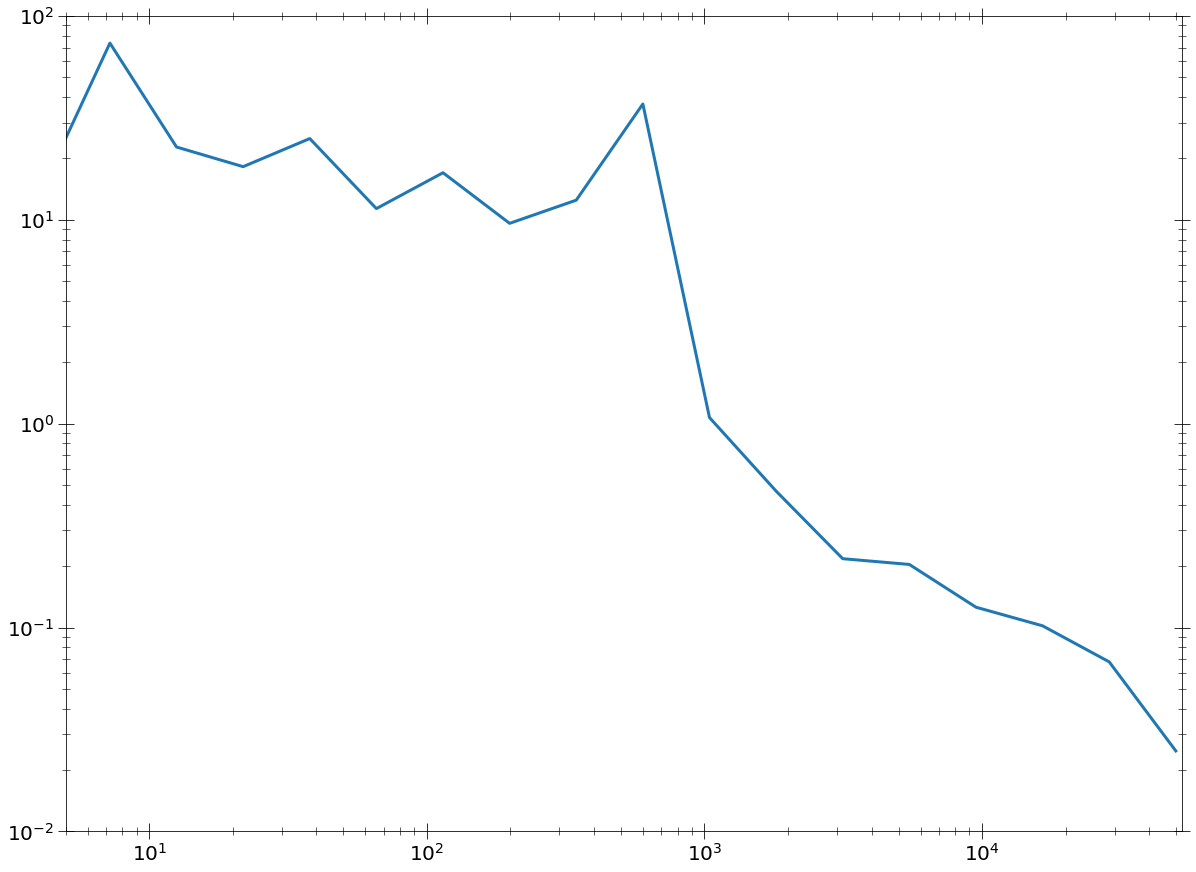

In [174]:
plt.plot(netcount_bincentres, colors_std_netcounts)
plt.xlim(5)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.01, 100)

In [160]:
interested_netcount_bins = 10**np.histogram(
    np.log10(interested_netcount[interested_netcount > 1]), bins=20)[1]

In [184]:
interested_netcount_bins

array([1.00260837e+00, 1.55954882e+00, 2.42586495e+00, 3.77341233e+00,
       5.86951085e+00, 9.12997430e+00, 1.42015975e+01, 2.20904644e+01,
       3.43615299e+01, 5.34490680e+01, 8.31395716e+01, 1.29322898e+02,
       2.01160670e+02, 3.12903714e+02, 4.86719072e+02, 7.57087384e+02,
       1.17764300e+03, 1.83181369e+03, 2.84937064e+03, 4.43217185e+03,
       6.89420569e+03])

In [178]:
(np.histogram(
    np.log10(interested_netcount[interested_netcount > 1]), bins=20)[1]

(array([225, 316, 494, 577, 707, 744, 718, 617, 556, 467, 363, 298, 165,
        127,  67,  60,  33,  16,   6,   2]),
 array([1.13132804e-03, 1.92998973e-01, 3.84866619e-01, 5.76734264e-01,
        7.68601910e-01, 9.60469555e-01, 1.15233720e+00, 1.34420485e+00,
        1.53607249e+00, 1.72794014e+00, 1.91980778e+00, 2.11167543e+00,
        2.30354307e+00, 2.49541072e+00, 2.68727836e+00, 2.87914601e+00,
        3.07101365e+00, 3.26288130e+00, 3.45474895e+00, 3.64661659e+00,
        3.83848424e+00]))

In [193]:
mask = np.logical_and(interested_netcount >=9.13, interested_netcount<14.2)
print(len(np.where(mask)[0]))

1:45: E225 missing whitespace around operator
1:70: E225 missing whitespace around operator


743


In [234]:
colors_test = sim_pn_fe_net/(sim_pn_cont1_net + sim_pn_cont2_net)
sim_pn_cont2_net[5888]

-2.8553513376278437

2.105641652745586 298.8943583472544
10.19073646898699 49.80926353101301


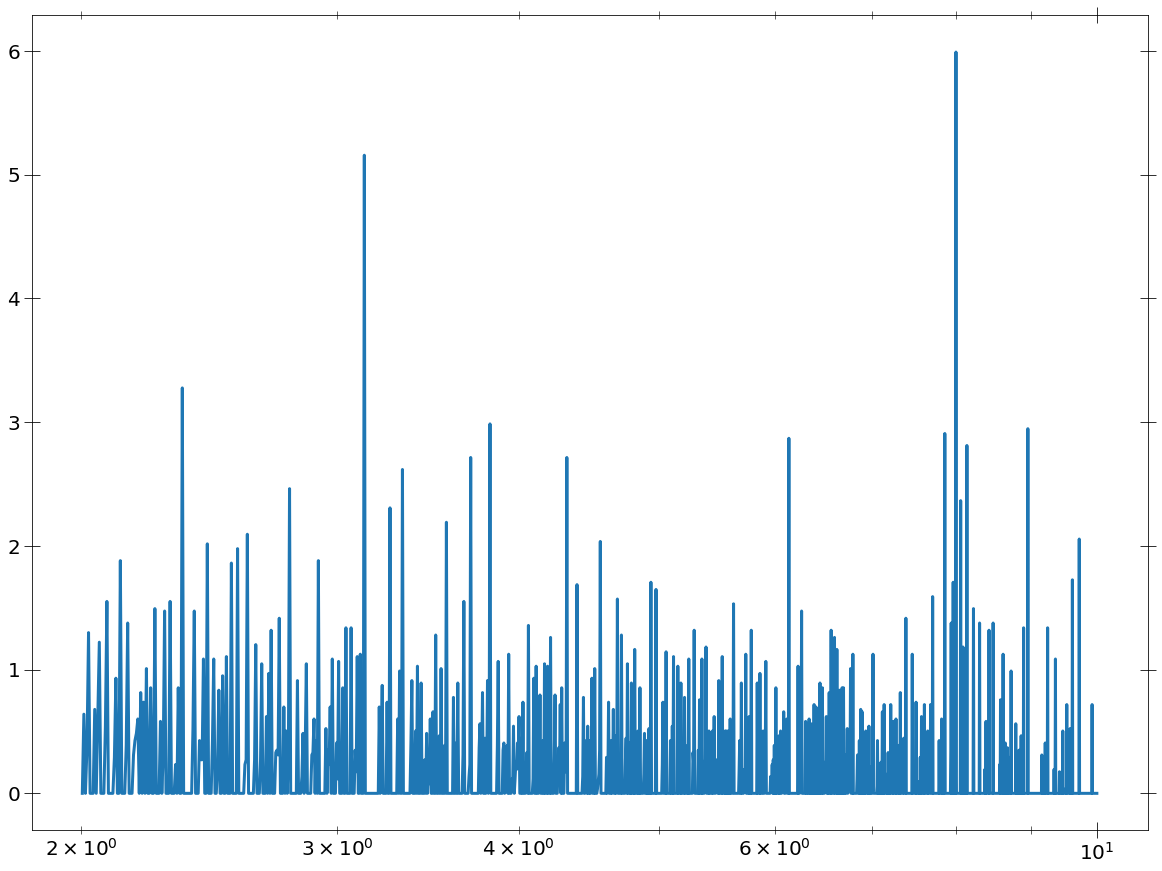

In [227]:
plt.plot(pn_ecentres[400:2000], sim_pn_bgs[sim_pn_mask][5888][400:2000])
plt.xscale('log')
print(sim_pn_netcounts[5888], sim_pn_bgcounts[5888])
print(interested_netcount[5888], interested_bg[5888])

In [176]:
mean_colors_interestedcounts, colors_std_interestedcounts = get_expected_colors(
    sim_pn_fe_net, sim_pn_cont1_net, sim_pn_cont2_net, interested_netcount, interested_netcount_bins)

1:80: E501 line too long (80 > 79 characters)


225
316
494
577
707
744
718
617
556
467
363
298
165
127
67
60
33
16
6
2


(-10.0, 10.0)

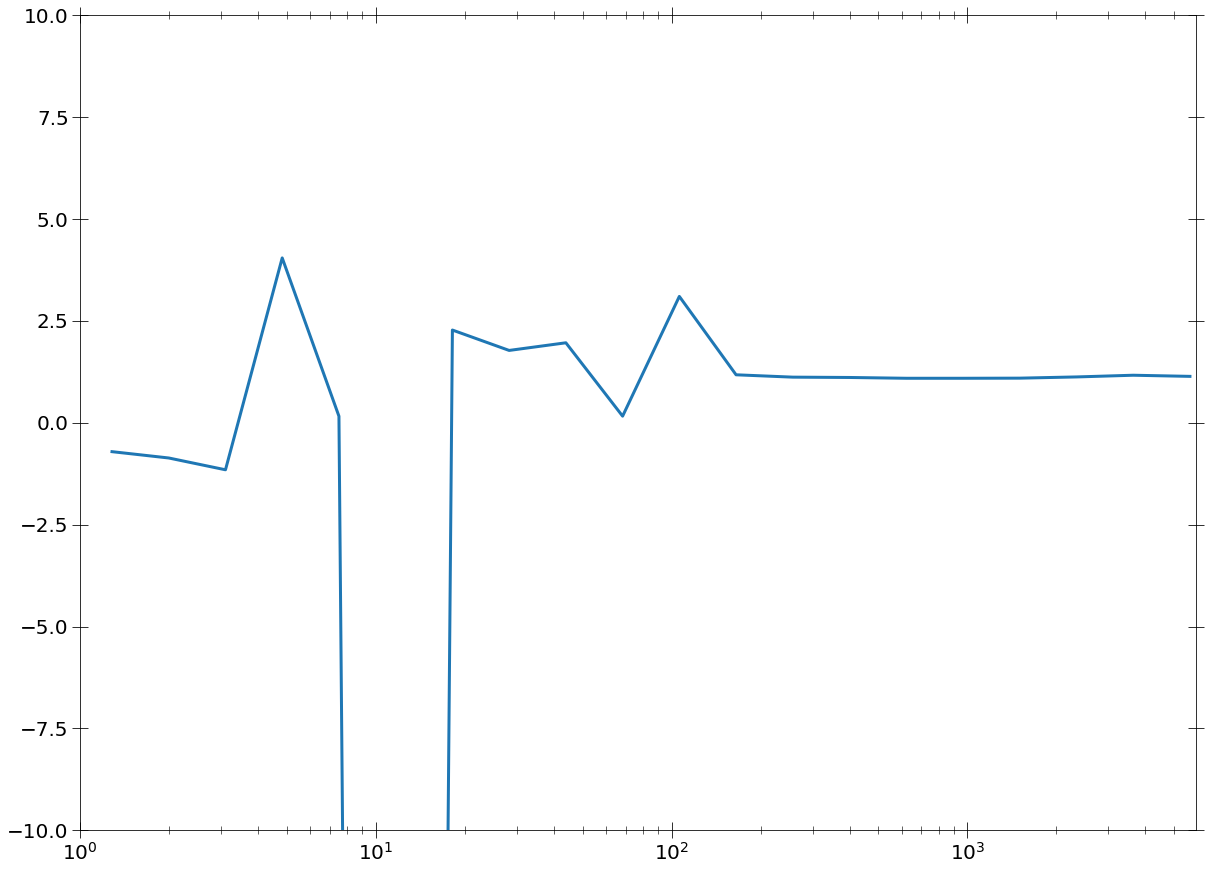

1:80: E501 line too long (104 > 79 characters)


In [246]:
plt.plot(0.5*(interested_netcount_bins[1:]+interested_netcount_bins[:-1]), mean_colors_interestedcounts)
plt.xlim(1)
plt.xscale('log')
plt.ylim(-10, 10)

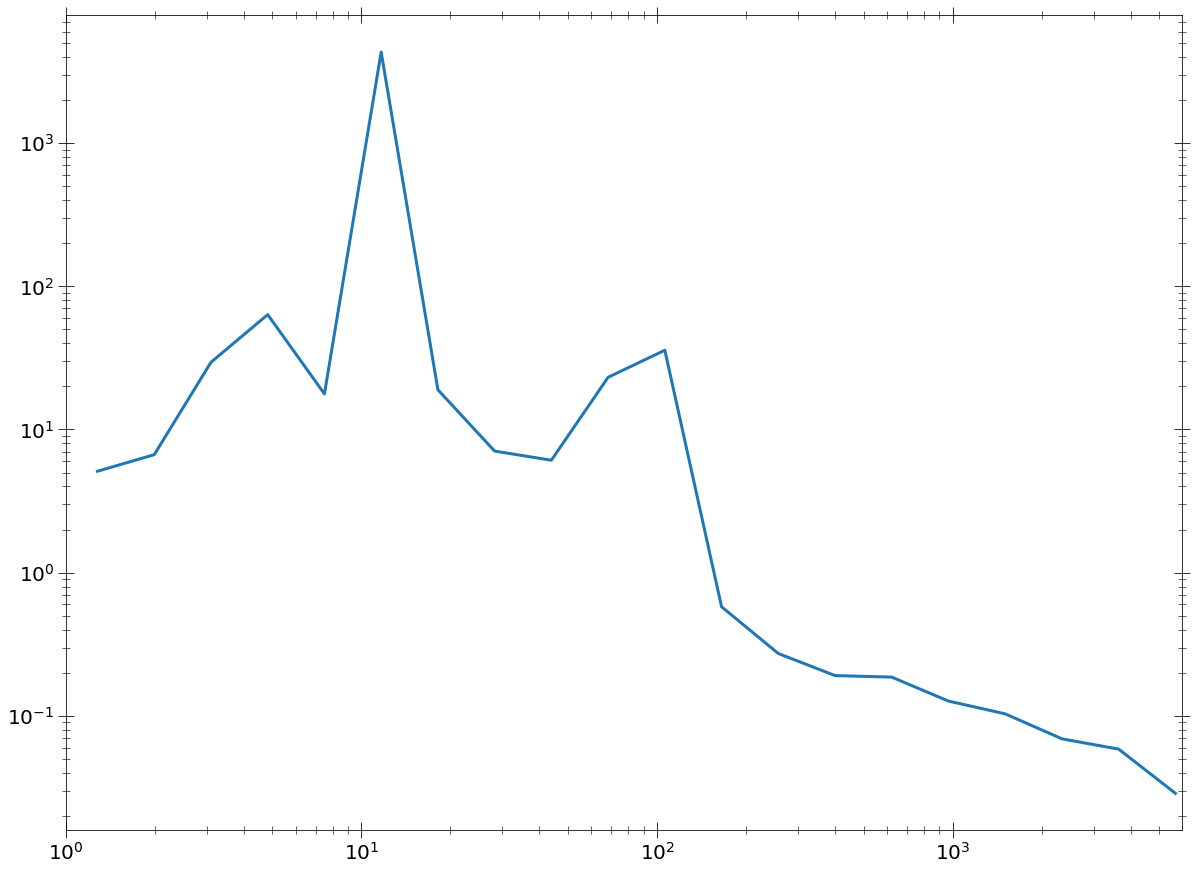

1:80: E501 line too long (103 > 79 characters)


In [217]:
plt.plot(0.5*(interested_netcount_bins[1:]+interested_netcount_bins[:-1]), colors_std_interestedcounts)
plt.xlim(1)
plt.xscale('log')
plt.yscale('log')

In [96]:
bg_ratio_bins = 10**(np.histogram(np.log10((sim_pn_bgcounts/sim_pn_netcounts)[sim_pn_netcounts > 1]), bins=20)[1])

In [218]:
mean_colors_bgratio, colors_std_bgratio = get_expected_colors(
    sim_pn_fe_net, sim_pn_cont1_net, sim_pn_cont2_net, sim_pn_bgcounts/sim_pn_netcounts, bg_ratio_bins)

4
38
126
299
509
654
761
795
874
947
895
724
490
347
179
89
48
23
10
7


(-2.0, 5.0)

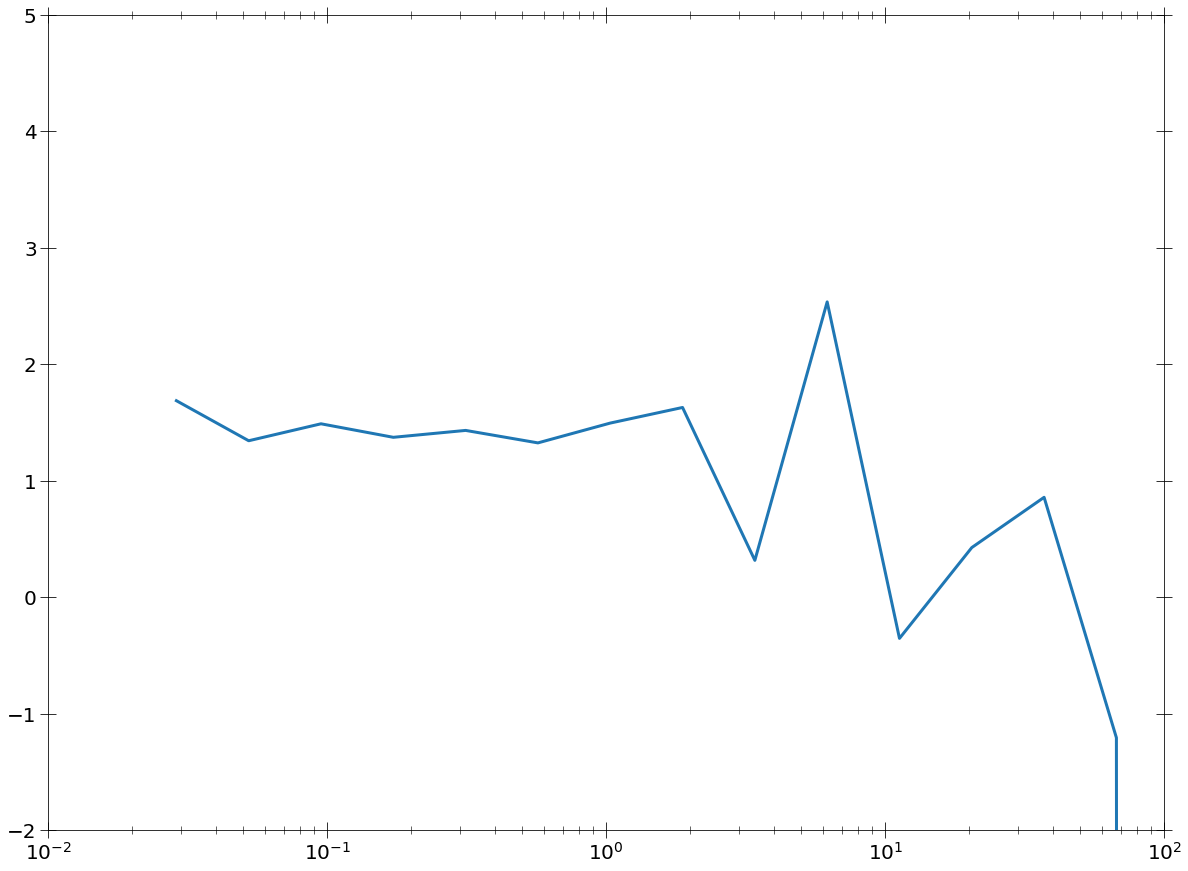

In [235]:
plt.plot(0.5*(bg_ratio_bins[1:]+bg_ratio_bins[:-1]), mean_colors_bgratio)
plt.xscale('log')
plt.xlim(0.01, 100)
plt.ylim(-2, 5)

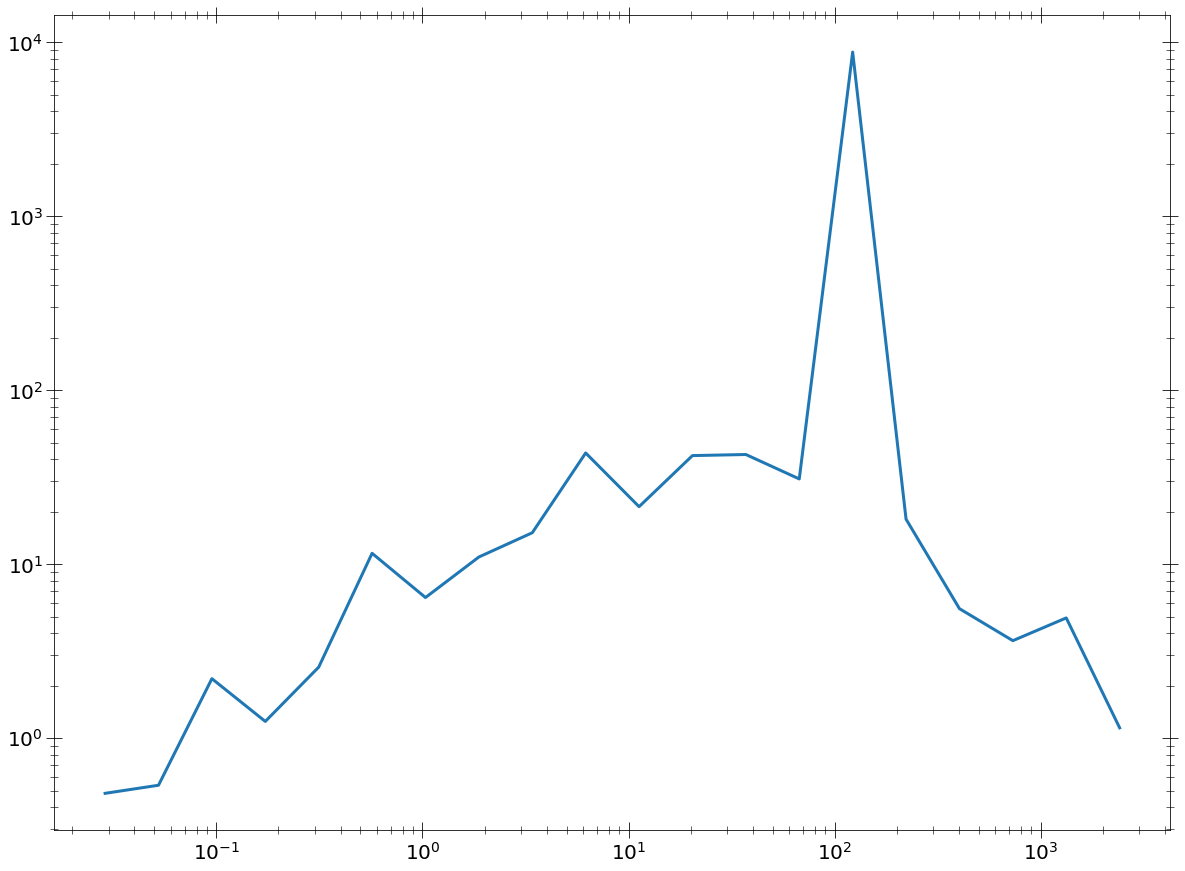

In [236]:
plt.plot(0.5*(bg_ratio_bins[1:]+bg_ratio_bins[:-1]), colors_std_bgratio)
plt.xscale('log')
plt.yscale('log')

In [106]:
nh_vals_bins = 10**(np.histogram(np.log10(nh_vals), bins=20)[1])

In [107]:
nh_vals_bins

array([5.01387079e+22, 5.62544288e+22, 6.31161211e+22, 7.08147755e+22,
       7.94524812e+22, 8.91437800e+22, 1.00017185e+23, 1.12216885e+23,
       1.25904656e+23, 1.41262007e+23, 1.58492587e+23, 1.77824884e+23,
       1.99515259e+23, 2.23851340e+23, 2.51155839e+23, 2.81790833e+23,
       3.16162562e+23, 3.54726818e+23, 3.97994990e+23, 4.46540842e+23,
       5.01008124e+23])

In [228]:
mean_colors_nhvals, colors_std_nhvals = get_expected_colors(
    sim_pn_fe_net, sim_pn_cont1_net, sim_pn_cont2_net, nh_vals[sim_pn_mask], nh_vals_bins)

454
476
408
449
439
470
446
449
461
454
436
498
497
456
446
469
454
496
466
449


(-10.0, 5.0)

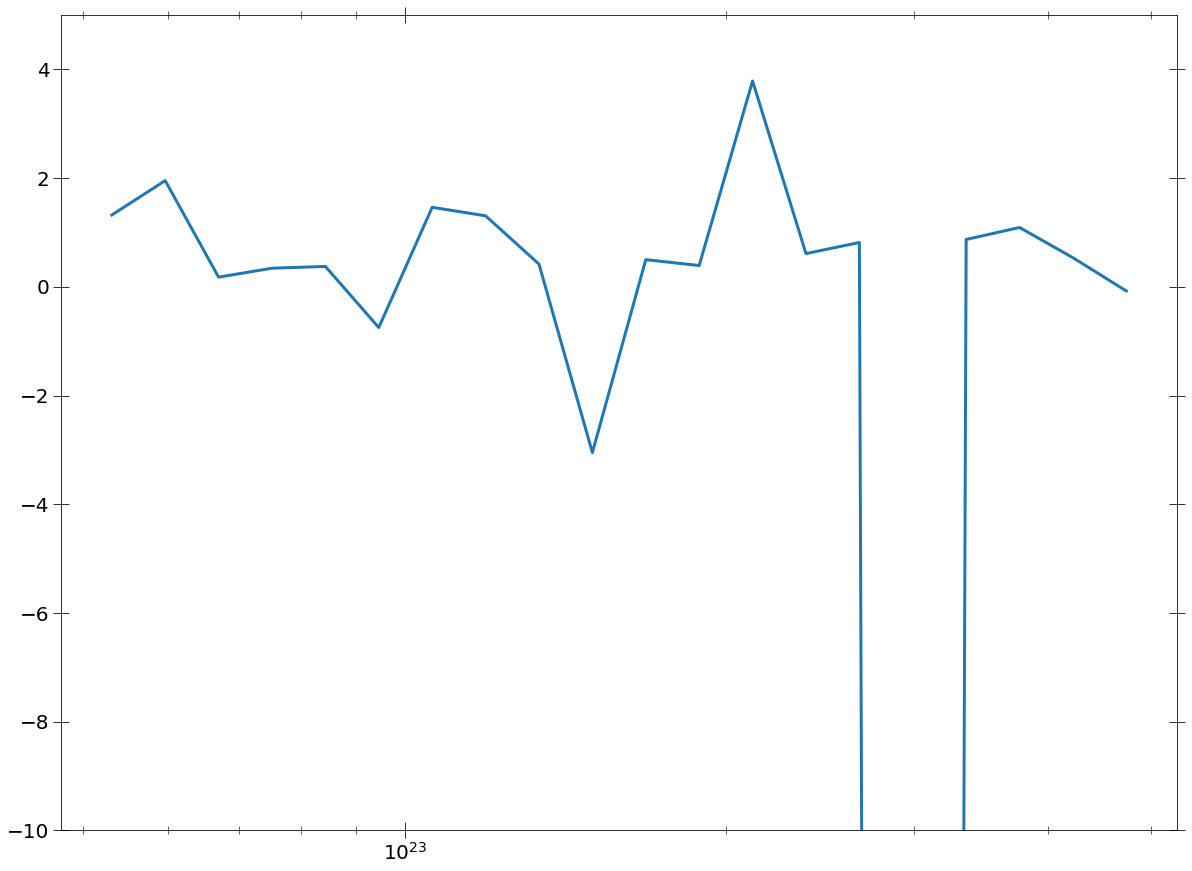

In [238]:
plt.plot(0.5*(nh_vals_bins[1:]+nh_vals_bins[:-1]), mean_colors_nhvals)
plt.xscale('log')
plt.ylim(-10, 5)

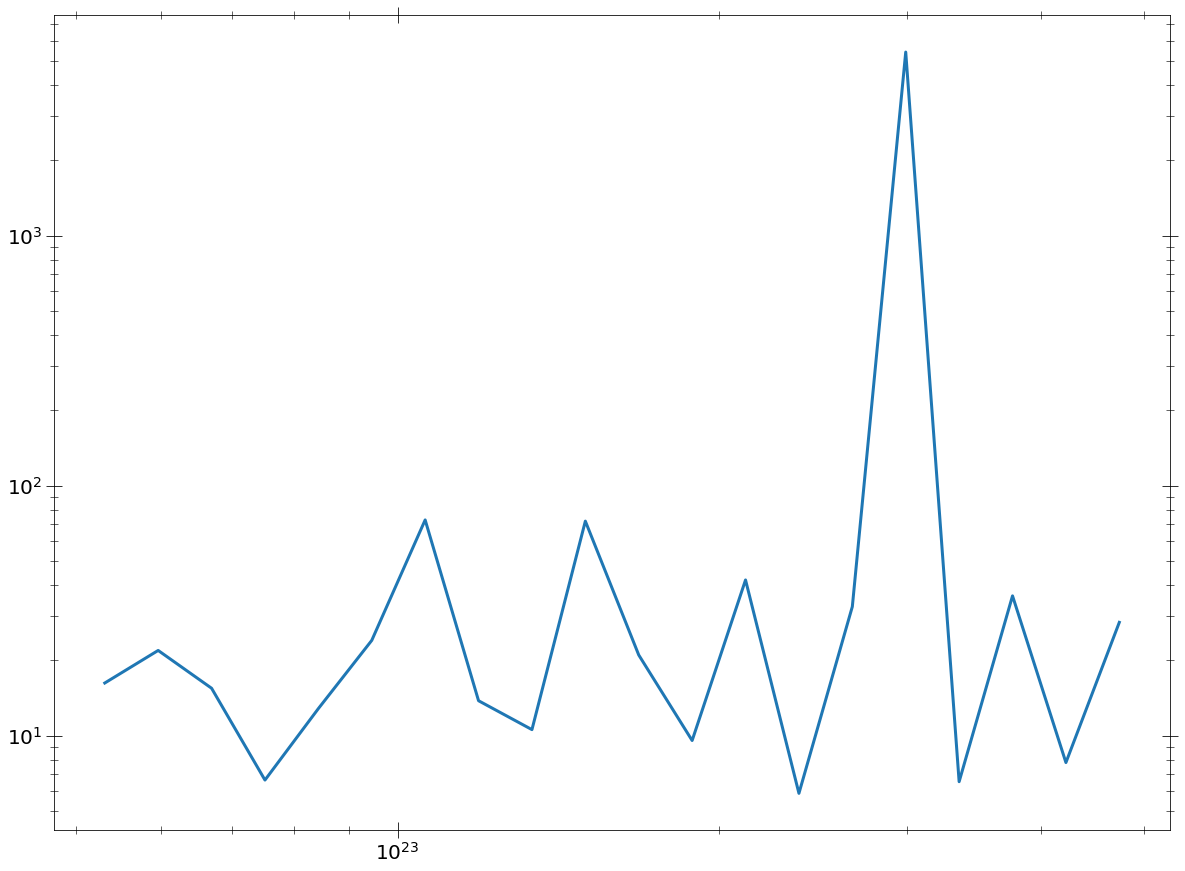

In [239]:
plt.plot(0.5*(nh_vals_bins[1:]+nh_vals_bins[:-1]), colors_std_nhvals)
plt.xscale('log')
plt.yscale('log')

In [116]:
lx_vals_bins = 10**(np.histogram(np.log10(lx_vals), bins=20)[1])

In [117]:
lx_vals_bins

array([1.00012648e+31, 1.41270450e+31, 1.99548160e+31, 2.81866932e+31,
       3.98144323e+31, 5.62389143e+31, 7.94389194e+31, 1.12209526e+32,
       1.58498855e+32, 2.23883727e+32, 3.16241549e+32, 4.46699358e+32,
       6.30974384e+32, 8.91267619e+32, 1.25893854e+33, 1.77828321e+33,
       2.51187098e+33, 3.54808265e+33, 5.01175842e+33, 7.07923824e+33,
       9.99960692e+33])

In [240]:
mean_colors_lxvals, colors_std_lxvals = get_expected_colors(
    sim_pn_fe_net, sim_pn_cont1_net, sim_pn_cont2_net, lx_vals[sim_pn_mask], lx_vals_bins)

482
462
450
456
463
436
445
479
460
446
469
427
422
466
484
452
444
471
486
473


(-5.0, 10.0)

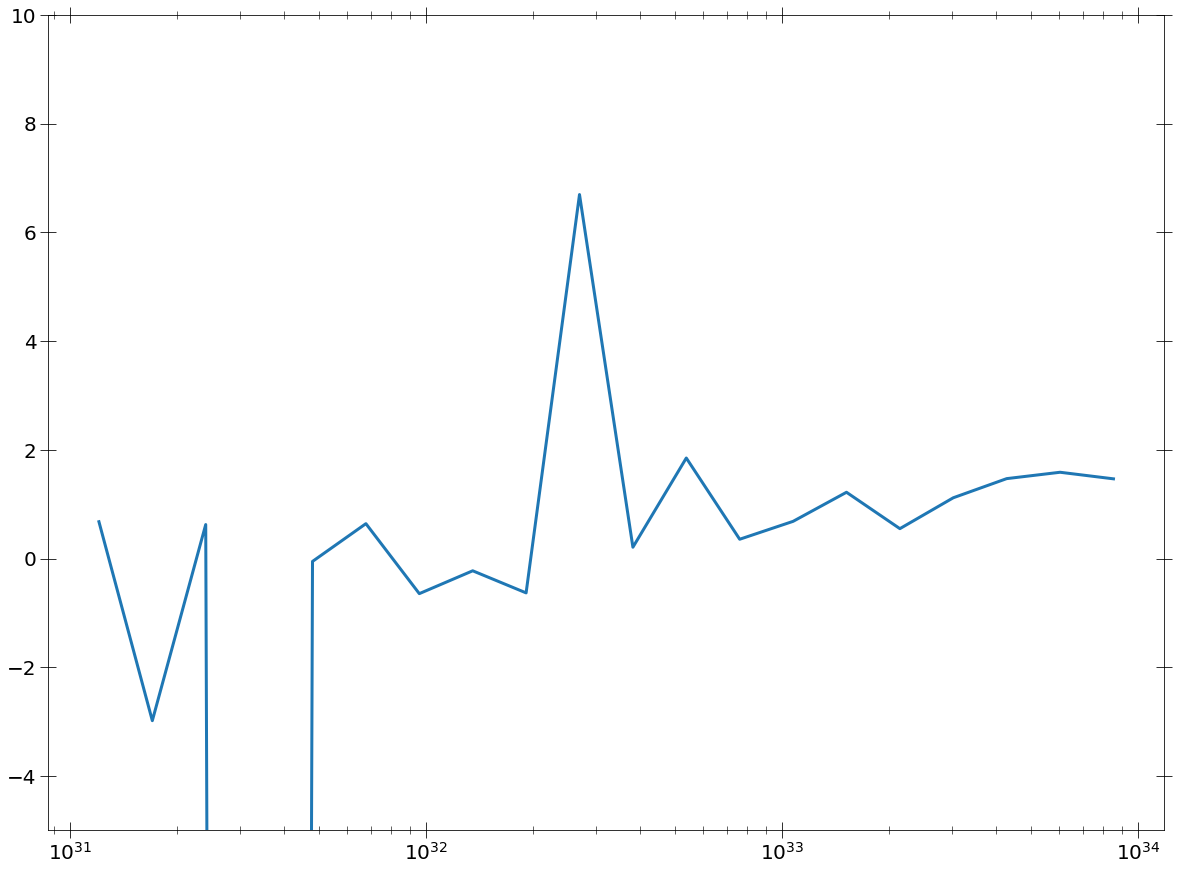

In [244]:
plt.plot(0.5*(lx_vals_bins[1:]+lx_vals_bins[:-1]), mean_colors_lxvals)
plt.xscale('log')
plt.ylim(-5, 10)

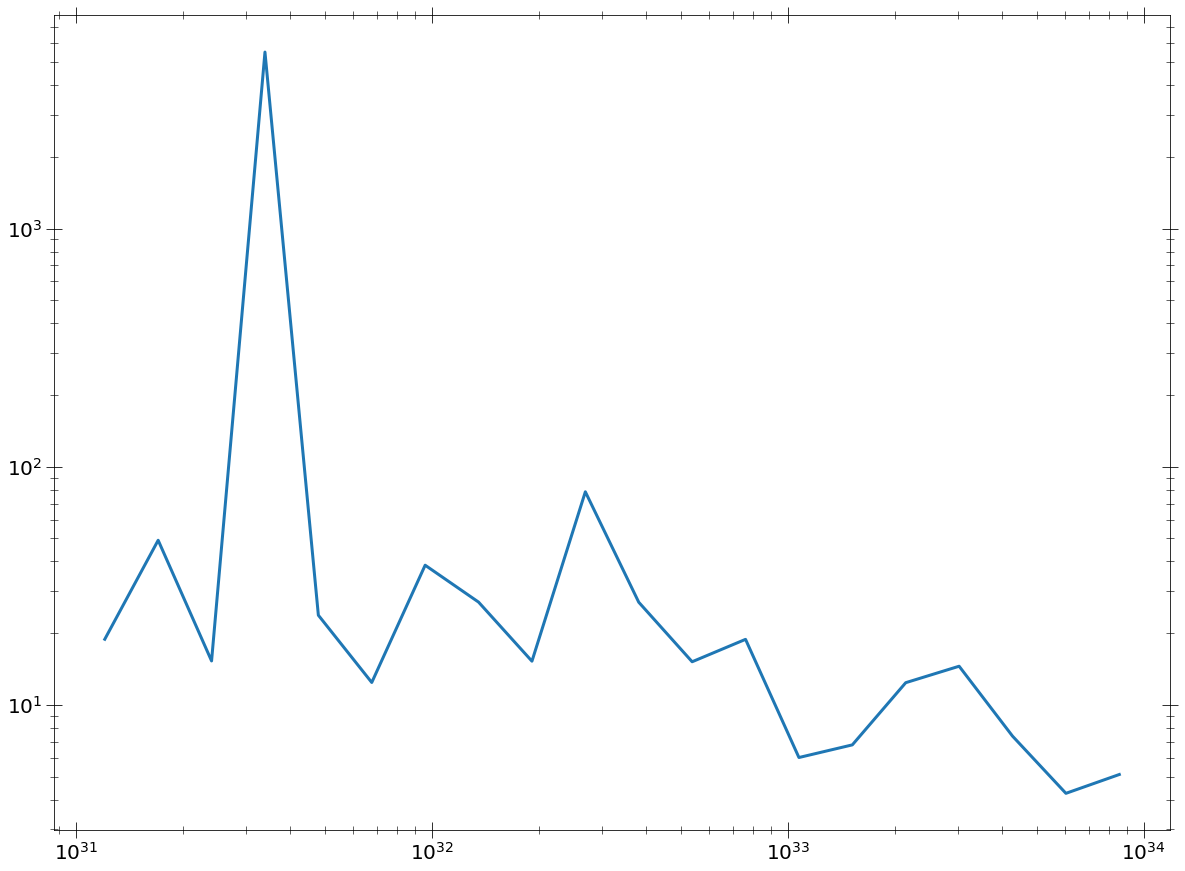

In [245]:
plt.plot(0.5*(lx_vals_bins[1:]+lx_vals_bins[:-1]), colors_std_lxvals)
plt.xscale('log')
plt.yscale('log')

In [144]:
def get_expected_colors_2props(counts_line_net, counts_cont1_net,
                               counts_cont2_net, src_prop1, src_prop2,
                               srcprop1_bins, srcprop2_bins):
    """Get expected color for given bins"""
    colors = counts_line_net/(counts_cont1_net + counts_cont2_net)
    mean_colors = np.zeros((len(srcprop1_bins)-1, len(srcprop2_bins)-1))
    colors_std = np.zeros((len(srcprop1_bins)-1, len(srcprop2_bins)-1))
    for i, bin1_edge in enumerate(srcprop1_bins[:-1]):
        for j, bin2_edge in enumerate(srcprop2_bins[:-1]):
            mean_colors[i, j], colors_std[i, j] = get_expected_color_bins_2prop(
                colors, src1_prop, src2_prop, [bin1_edge, srcprop1_bins[i+1]],
                [bin2_edge, srcprop2_bins[i+1]])
    return mean_colors, colors_std


def get_expected_color_bins_2prop(colors, src1_prop, src2_prop, bin1_edges,
                                  bin2_edges):
    """Get expected color for each bin"""
    mask = np.where(np.logical_and(
        np.logical_and(src1_prop >= bin1_edges[0], src1_prop < bin1_edges[1]),
        np.logical_and(src2_prop >= bin2_edges[0], src2_prop < bin2_edges[1])))
    bin_colors = colors[mask]
    return np.mean(bin_colors), np.std(bin_colors)

1:1: E302 expected 2 blank lines, found 0
10:80: E501 line too long (80 > 79 characters)


In [247]:
mean_colors_nh_lx, colors_std_nh_lx = get_expected_color_bins_2prop(
    sim_pn_fe_net, sim_pn_cont1_net, sim_pn_cont2_net, sim_pn_netcounts,
    sim_mos_bgcounts)

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
plt.imshow()